# 0.0 IMPORTS

In [8]:
import pandas     as pd
import numpy      as np
import seaborn    as sns
import scikitplot as skplt

import matplotlib.gridspec as gridspec

from matplotlib import pyplot as plt
from IPython.core.display import HTML
from IPython.display      import Image

from boruta                  import BorutaPy
from xgboost                 import XGBClassifier
from lightgbm                import LGBMClassifier
from catboost                import CatBoostClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.ensemble        import RandomForestRegressor, ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing   import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from category_encoders       import TargetEncoder
from feature_engine.encoding import CountFrequencyEncoder

## 0.1 Helper functions

In [45]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
# compute precision at k
def precision_at_k(data, yhat, k=20000):
    # propensity score
    data['score'] = yhat[:,1].tolist()

    # sort clients by propensity score
    data = data.sort_values('score', ascending=False)

    #reset index
    data = data.reset_index(drop=True)

    # create ranking order
    data['ranking'] = data.index + 1

    data['precision_at_k'] = data['response'].cumsum()/data['ranking']

    return data.loc[k, 'precision_at_k']


def recall_at_k(data, yhat, k=20000):
    # propensity score
    data['score'] = yhat[:,1].tolist()

    # sort clients by propensity score
    data = data.sort_values('score', ascending=False)

    #reset index
    data = data.reset_index(drop=True)

    # create ranking order
    data['ranking'] = data.index + 1

    data['recall_at_k'] = data['response'].cumsum()/data['response'].sum()

    return data.loc[k, 'recall_at_k']


def cross_validation(model, kfold, X_train, y_train):
    precision_list = []
    recall_list = []
    skf = StratifiedKFold(n_splits=kfold)

    for train, test in skf.split(X_train, y_train):
        # test dataset
        X_train_fold = X_train.iloc[train]
        y_train_fold = y_train.iloc[train]

        # validation dataset
        X_test_fold = X_train.iloc[test]
        y_test_fold = y_train.iloc[test]

        # Encoding
        ss = StandardScaler()

        # annual_premium
        X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
        
        mms_age = MinMaxScaler()
        mms_vintage = MinMaxScaler()

        # age (since its distribution is not a normal one)
        X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)

        # vintage
        X_train_fold['vintage'] = mms_vintage.fit_transform(X_train_fold[['vintage']].values)
        
        # gender
        le = LabelEncoder()
        X_train_fold['gender'] = le.fit_transform(X_train_fold['gender'])

        # region_code - Target Enconder
        te = TargetEncoder()
        X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
        X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)

        # vehicle_age - Ordinal Encoding
        vehicle_age_dict = {'below_1_year': 1, 'between_1_2_years': 2, 'over_2_years': 3}
        X_train_fold['vehicle_age'] = X_train_fold['vehicle_age'].map(vehicle_age_dict)

        # policy_sales_channel - Frequency Encoding
        X_train_fold['policy_sales_channel'] = X_train_fold['policy_sales_channel'].astype(str)
        cfe = CountFrequencyEncoder(encoding_method='frequency', variables=['policy_sales_channel'])
        X_train_fold = cfe.fit_transform(X_train_fold)
        
        # annual_premium
        X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)

        # age (since its distribution is not a normal one)
        X_test_fold['age'] = mms_age.transform(X_test_fold[['age']].values)

        # vintage
        X_test_fold['vintage'] = mms_vintage.transform(X_test_fold[['vintage']].values)

        # gender
        X_test_fold['gender'] = le.transform(X_test_fold['gender'])

        # region_code - Target Enconder
        X_test_fold['region_code'] = X_test_fold['region_code'].astype(str)
        X_test_fold['region_code'] = te.transform(X_test_fold['region_code'])

        # vehicle_age - Ordinal Encoding
        vehicle_age_dict = {'below_1_year': 1, 'between_1_2_years': 2, 'over_2_years': 3}
        X_test_fold['vehicle_age'] = X_test_fold['vehicle_age'].map(vehicle_age_dict)

        # policy_sales_channel - Frequency Encoding
        X_test_fold['policy_sales_channel'] = X_test_fold['policy_sales_channel'].astype(str)
        X_test_fold = cfe.transform(X_test_fold)
        X_test_fold = X_test_fold.replace(np.nan, 0)
        
        cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage',
                         'policy_sales_channel', 'previously_insured']
        
        X_train_fold = X_train_fold[cols_selected]
        X_test_fold = X_test_fold[cols_selected]

        # Model training
        model.fit(X_train_fold, y_train_fold)

        # Predicting probability
        yhat = model.predict_proba(X_test_fold)

        df = X_test_fold.copy()
        df['response'] = y_test_fold.copy()

        precision_list.append(precision_at_k(df, yhat))
        recall_list.append(recall_at_k(df, yhat))

    return pd.DataFrame({'Model': type(model).__name__,
                       'Precision at k': np.round(np.mean(precision_list), 4).astype(str) + '+/-' +
                         np.round(np.std(precision_list), 4).astype(str),
                       'Recall at k': np.round(np.mean(recall_list), 4).astype(str) + '+/-' +
                         np.round(np.std(recall_list), 4).astype(str)}, index=[0])


In [10]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading dataset

In [11]:
data_raw = pd.read_csv('../data/raw/train.csv')

In [12]:
data_raw.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


# 1.0 ANÁLISE DESCRITIVA

In [13]:
df1 = data_raw.copy()

In [14]:
# columns in snakecase
cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code',
            'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
            'policy_sales_channel', 'vintage', 'response']

df1.columns = cols_new

## 1.1 Data informations

In [15]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   gender                381109 non-null  object 
 2   age                   381109 non-null  int64  
 3   driving_license       381109 non-null  int64  
 4   region_code           381109 non-null  float64
 5   previously_insured    381109 non-null  int64  
 6   vehicle_age           381109 non-null  object 
 7   vehicle_damage        381109 non-null  object 
 8   annual_premium        381109 non-null  float64
 9   policy_sales_channel  381109 non-null  float64
 10  vintage               381109 non-null  int64  
 11  response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


## 1.2 Análise Descritiva

In [16]:
# numerical features
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

# categorical features
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64'])

### 1.2.1 Atributos Numéricos

In [17]:
# Tendência Central - média, mediana
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersão - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = (['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


# 2.0 FEATURE ENGINEERING

In [18]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hipóteses

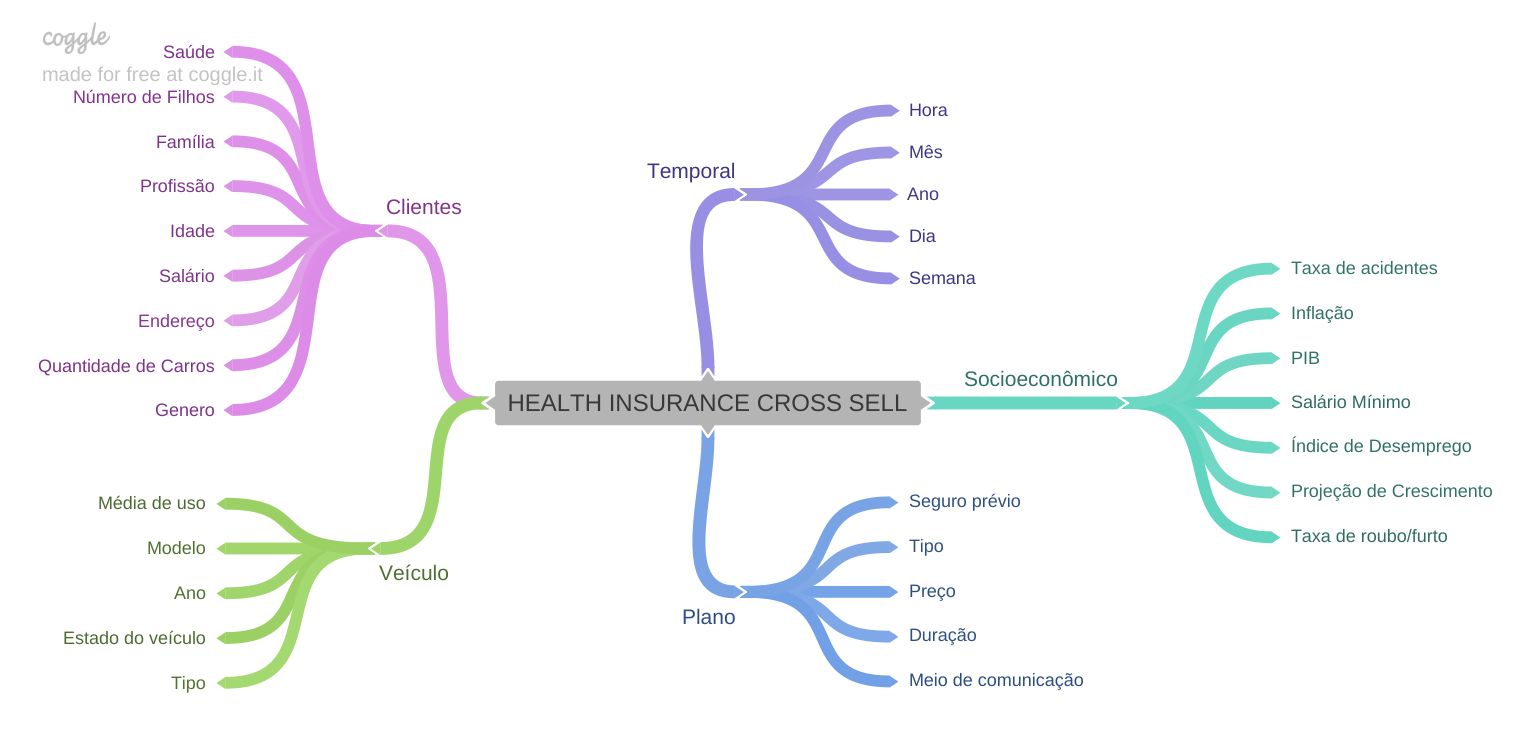

In [19]:
Image('../img/MindMap.png')

## 2.2 Criação de Hipóteses

### 2.2.1 Hipóteses Cliente

**1.** Clientes com mais de 40 anos são mais propensos a contratarem o seguro.

**2.** Clientes sem filhos são mais propensos a contratarem o seguro.

**3.** Clientes mulheres são mais propensas a contratarem o seguro.

**4.** Clientes com carteira de habilitação são mais propensos a contratarem o seguro.

### 2.2.2 Hipóteses Veículo

**1.** Clientes com veículo que apresenta algum dano são mais propensos a contratarem o seguro.

**2.** Clientes com veículos mais novos são mais propensos a contratarem o seguro.

**3.** Clientes que usam o veículo em mais dias da semana são mais propensos a contratarem o seguro.

### 2.2.3 Hipóteses Temporal

**1.** Clientes contatados no mês de janeiro são menos propensos a contratarem o seguro.

**2.** Clientes contatados na sexta-feira são menos propensos a contratarem o seguro.

**3.** Clientes contatados depois do meio dia são menos propensos a contratarem o seguro.

### 2.2.4 Hipóteses Plano

**1.** Clientes com annual premium maior são mais propensos a contratarem o seguro.

**2.** Clientes mais antigos são mais propensos a contratarem o seguro.

**3.** Clientes contatados por um determinado meio de comunicação são mais propensos a contratarem o seguro.

**4.** Clientes que já possuem seguro de veículo são menos propensos a contratarem o seguro.

### 2.2.5 Hipóteses Socioeconômico

**1.** Clientes que moram em regiões com maior taxa de acidentes são mais propensos a contratarem o seguro.

**2.** Clientes que moram em regiões com maior taxa de furto/roubo são mais propensos a contratarem o seguro.

**3.** Clientes que moram em regiões com menor índice de desemprego são mais propensos a contratarem o seguro.

## 2.3 Lista Final de Hipóteses

**1.** Clientes com mais de 40 anos são mais propensos a contratarem o seguro.

**2.** Clientes mulheres são mais propensas a contratarem o seguro.

**3.** Clientes com carteira de habilitação são mais propensos a contratarem o seguro.

**4.** Clientes com veículo que apresenta algum dano são mais propensos a contratarem o seguro.

**5.** Clientes com veículos mais novos são mais propensos a contratarem o seguro.

**6.** Clientes com planos mais caros são mais propensos a contratarem o seguro.

**7.** Clientes mais antigos são mais propensos a contratarem o seguro.

**8.** Clientes contatados por um determinado meio de comunicação são mais propensos a contratarem o seguro.

**9.** Clientes que já possuem seguro de veículo são menos propensos a contratarem o seguro.

**10.** Clientes que moram em regiões com maior taxa de acidentes são mais propensos a contratarem o seguro.

## 2.4 Feature Enginnering

In [20]:
# vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else
                                              'between_1_2_years' if x == '1-2 Year' else 'below_1_year')

# vehicle damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

# 3.0 FILTRAGEM DOS DADOS

In [21]:
df3 = df2.copy()

# 4.0 ANÁLISE EXPLORATÓRIA DOS DADOS

In [22]:
df4 = df3.copy()

## 4.1 Análise Univariada

### Variáveis Numéricas

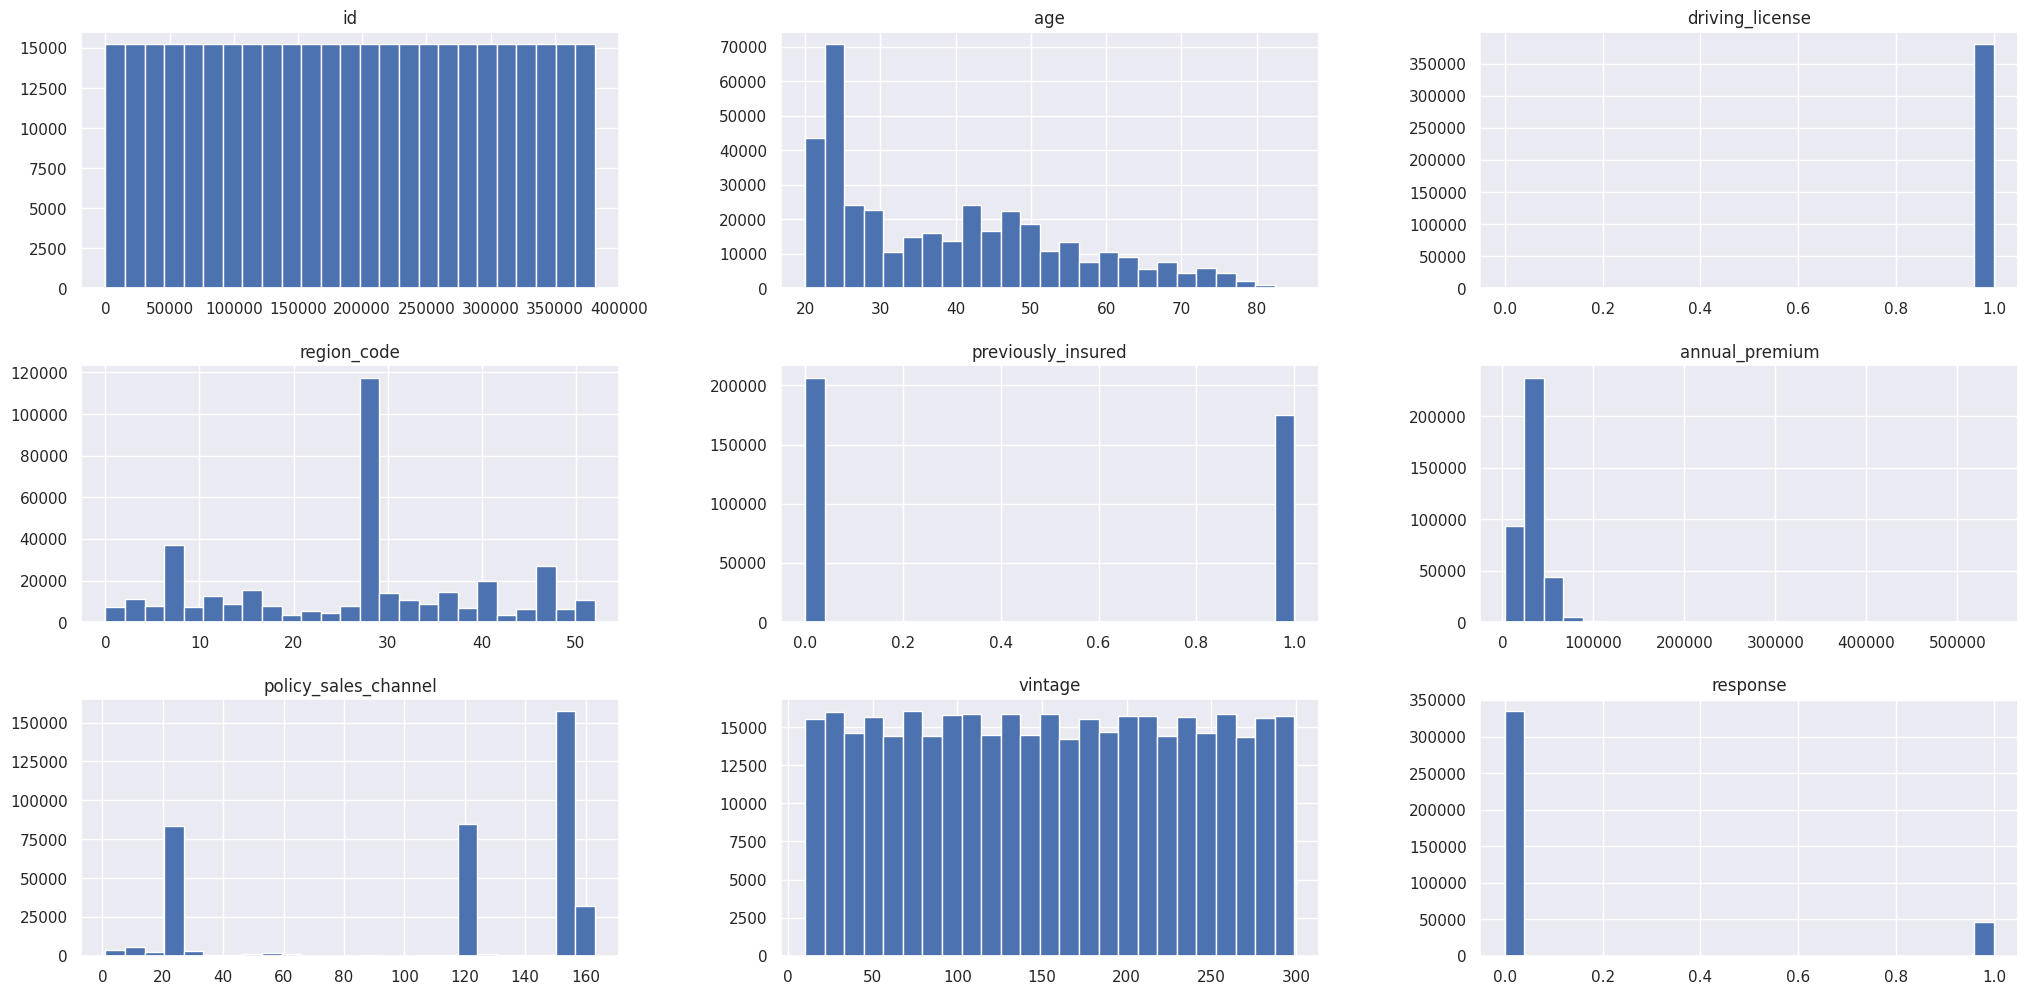

In [23]:
num_attributes.hist(bins=25);

### Variáveis Categóricas

## 4.2 Análise Bivariada

### H1. Clientes com mais de 40 anos são mais propensos a contratarem o seguro.
***VERDADEIRA.*** Clientes entre 40 e 50 anos são mais propensos a contratarem o seguro.

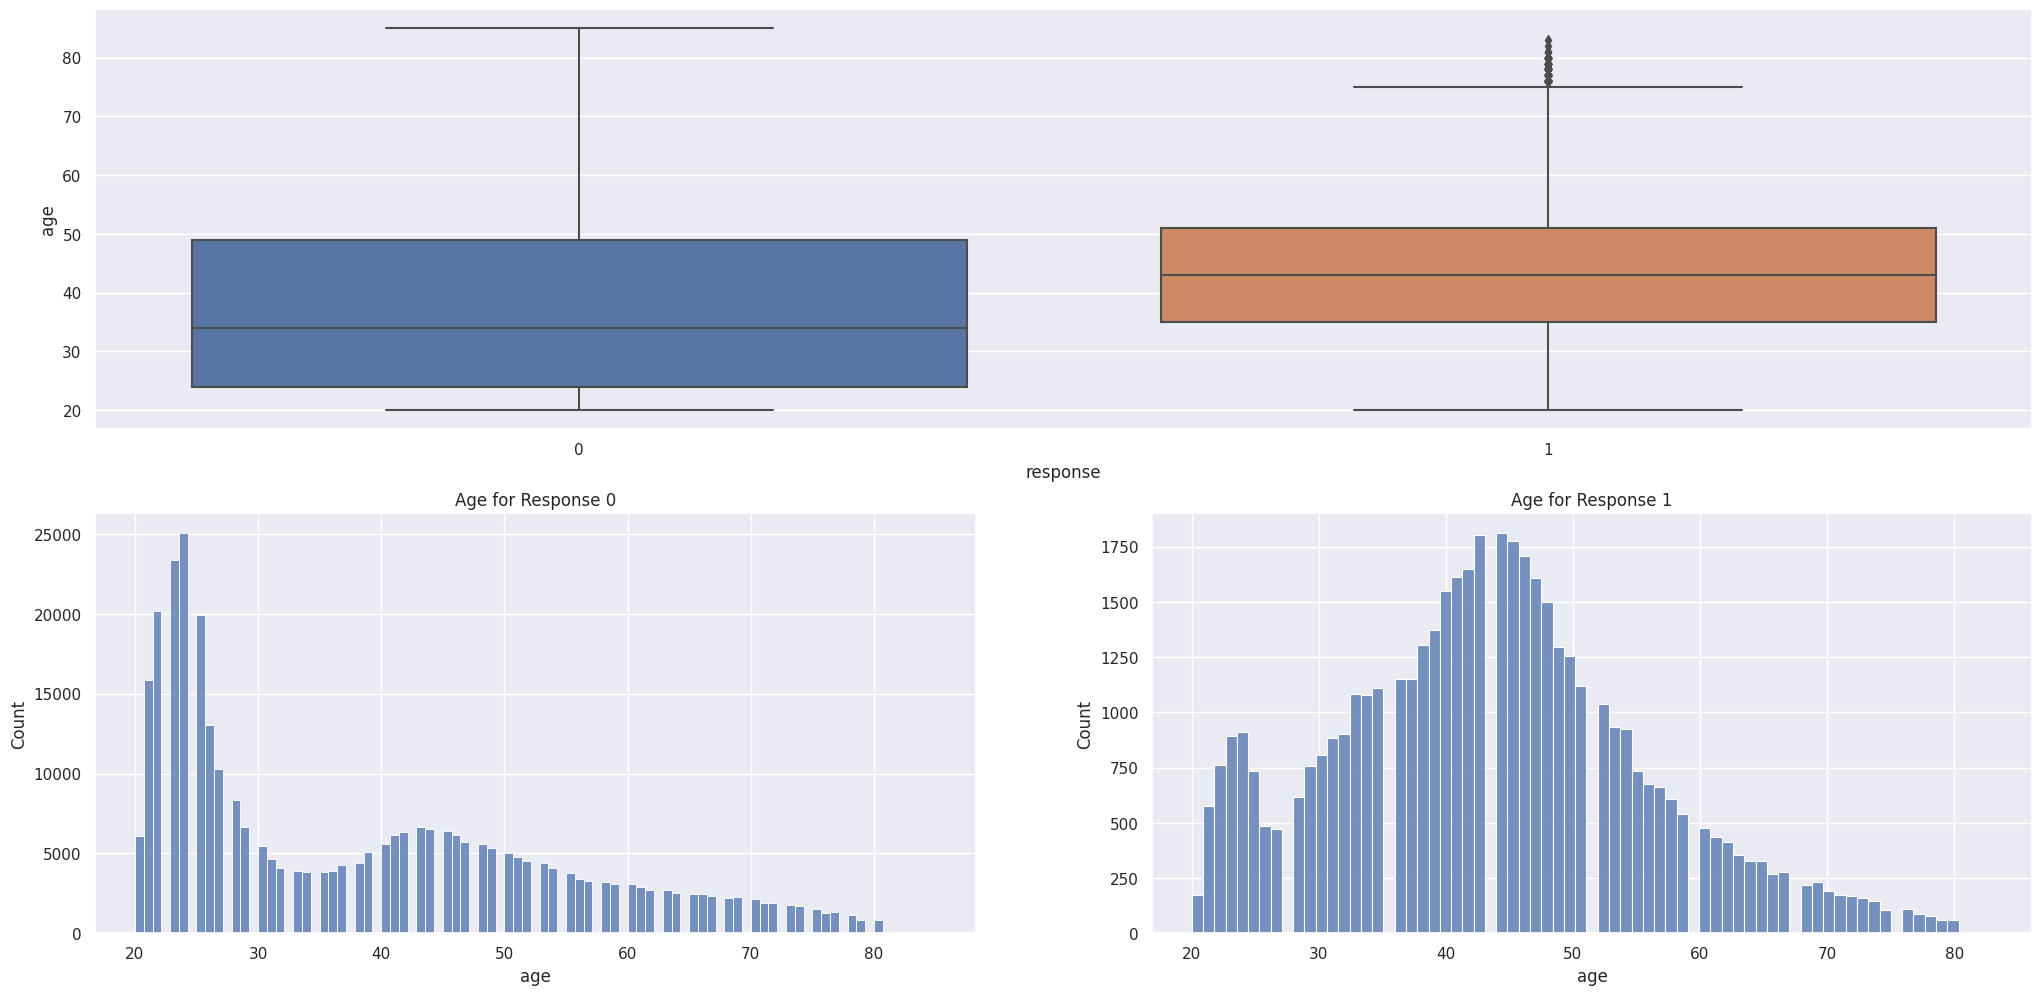

In [15]:
# 'age'
G = gridspec.GridSpec(2, 2)

ax1 = plt.subplot(G[0, :])
sns.boxplot(x='response', y='age', data=df4, ax=ax1)

ax2 = plt.subplot(G[1, 0])
sns.histplot(data=df4[df4['response'] == 0], x='age', ax=ax2)
plt.title('Age for Response 0')

ax3 = plt.subplot(G[1, 1])
sns.histplot(data=df4[df4['response'] == 1], x='age', ax=ax3)
plt.title('Age for Response 1');

### **H2.** Clientes mulheres são mais propensas a contratarem o seguro.
***FALSA.*** Clientes HOMENS são mais propensos a contratarem o seguro.

gender,Female,Male
response,,
0,0.469006,0.530994
1,0.389317,0.610683


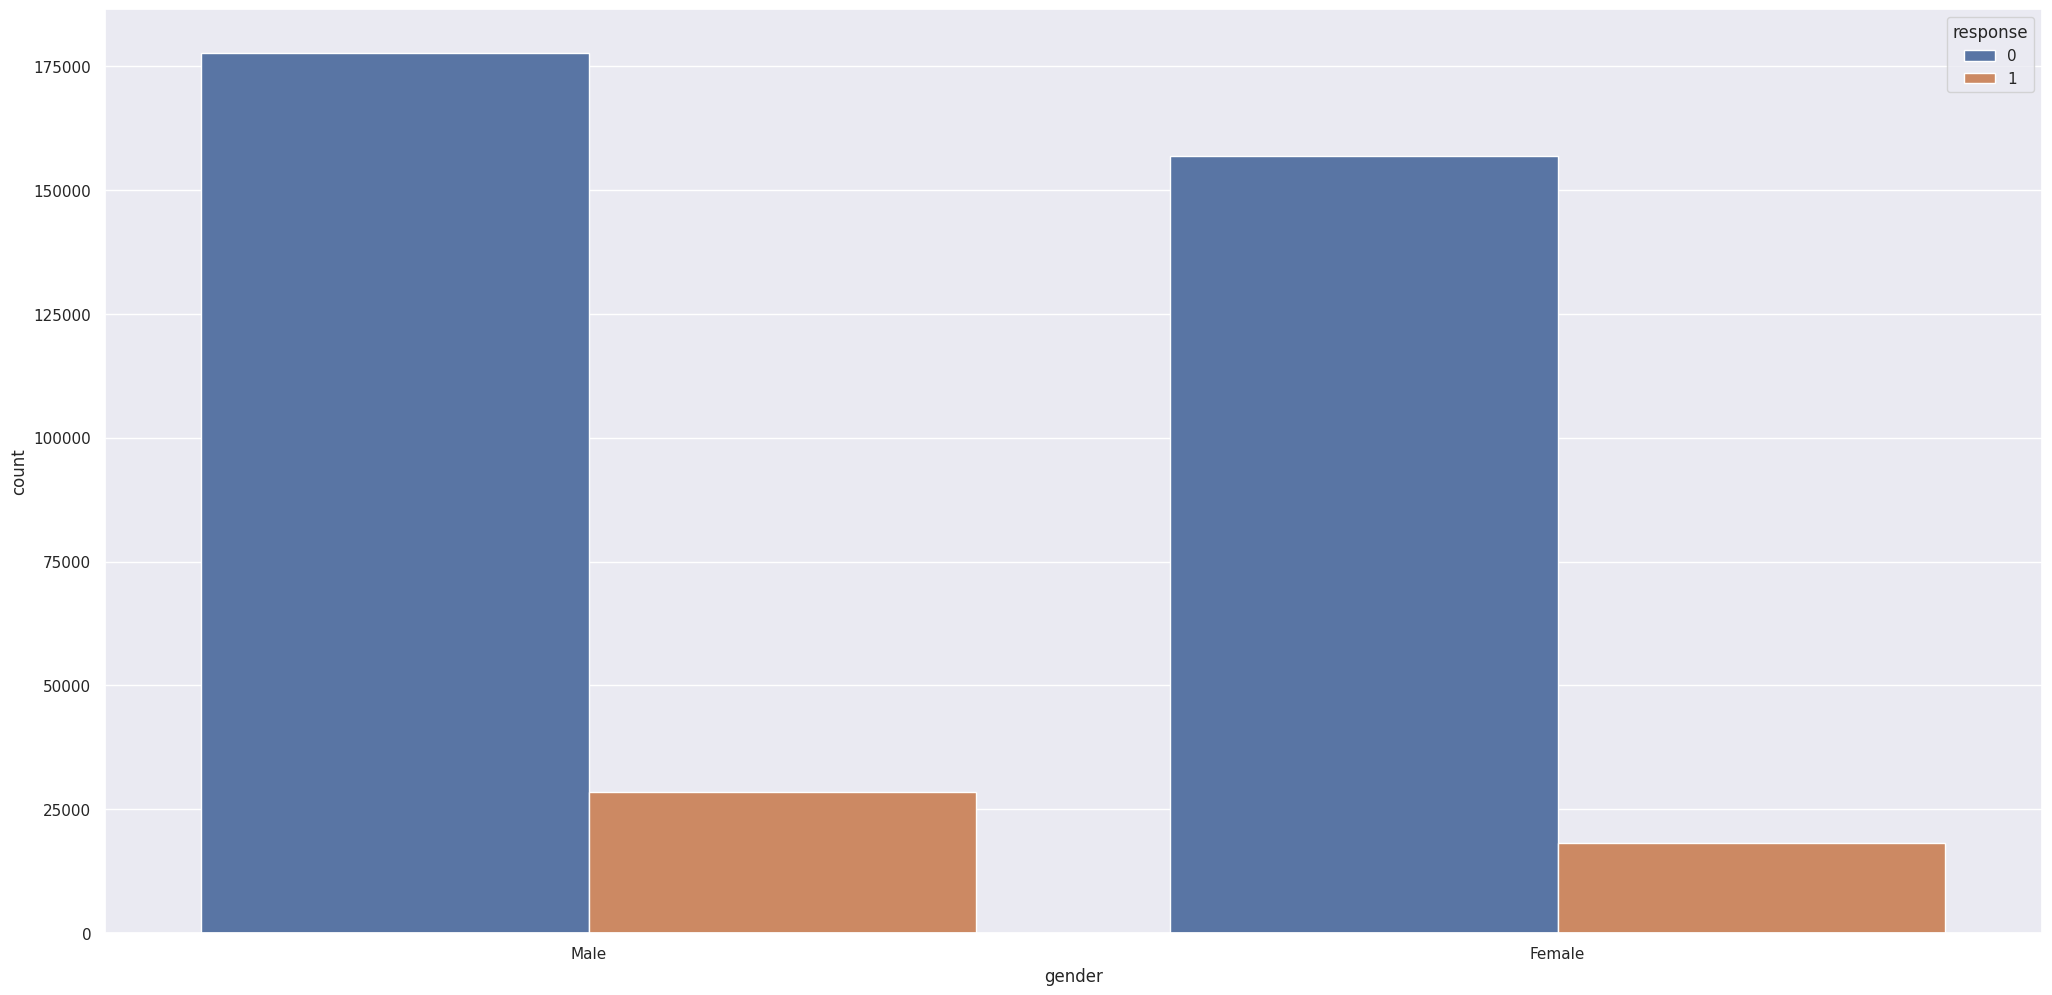

In [16]:
# 'gender'
sns.countplot(x=df4['gender'], hue=df4['response'])

pd.crosstab(df4['response'], df4['gender']).apply(lambda x: x/x.sum(), axis=1)

### **H3.** Clientes com carteira de habilitação são mais propensos a contratarem o seguro.
***VERDADEIRA.*** Clientes com CARTEIRA DE HABILITAÇÃO são mais propensos a contratarem o seguro.

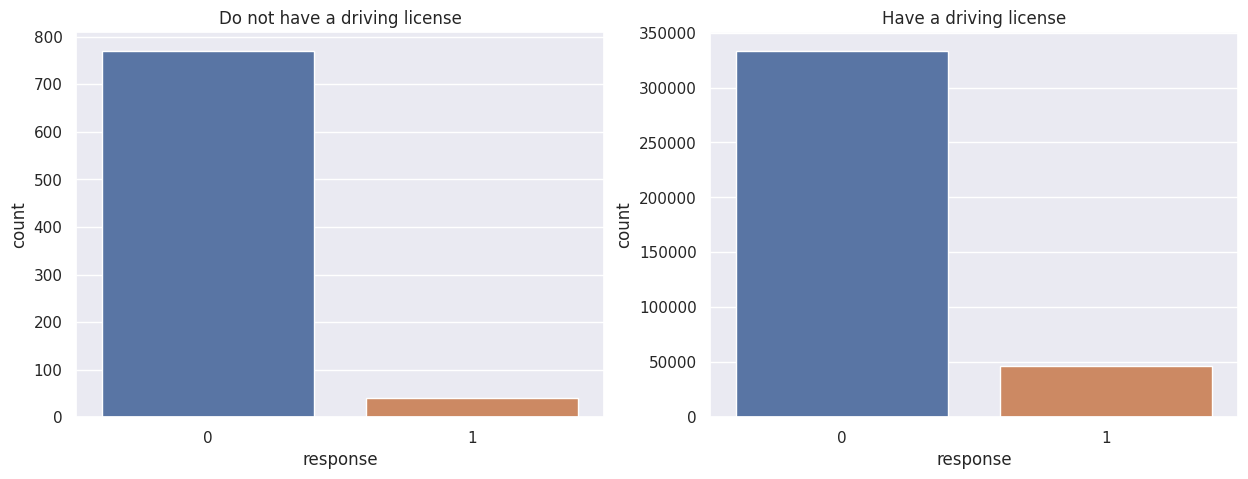

In [17]:
# 'driving_license'
plt.figure(figsize=(15, 5))
G = gridspec.GridSpec(1, 2)

ax1 = plt.subplot(G[0, 0])
sns.countplot(x='response', data=df4[df4['driving_license'] == 0], ax=ax1)
plt.title('Do not have a driving license')

ax2 = plt.subplot(G[0, 1])
sns.countplot(x='response', data=df4[df4['driving_license'] == 1], ax=ax2)
plt.title('Have a driving license');

### **H4.** Clientes com veículo que apresenta algum dano são mais propensos a contratarem o seguro.
***VERDADEIRA.*** Clientes com veículos que aprensentam algum DANO são mais propensos a contratarem o seguro.

response,0,1
vehicle_damage,,
0,0.994796,0.005204
1,0.762345,0.237655


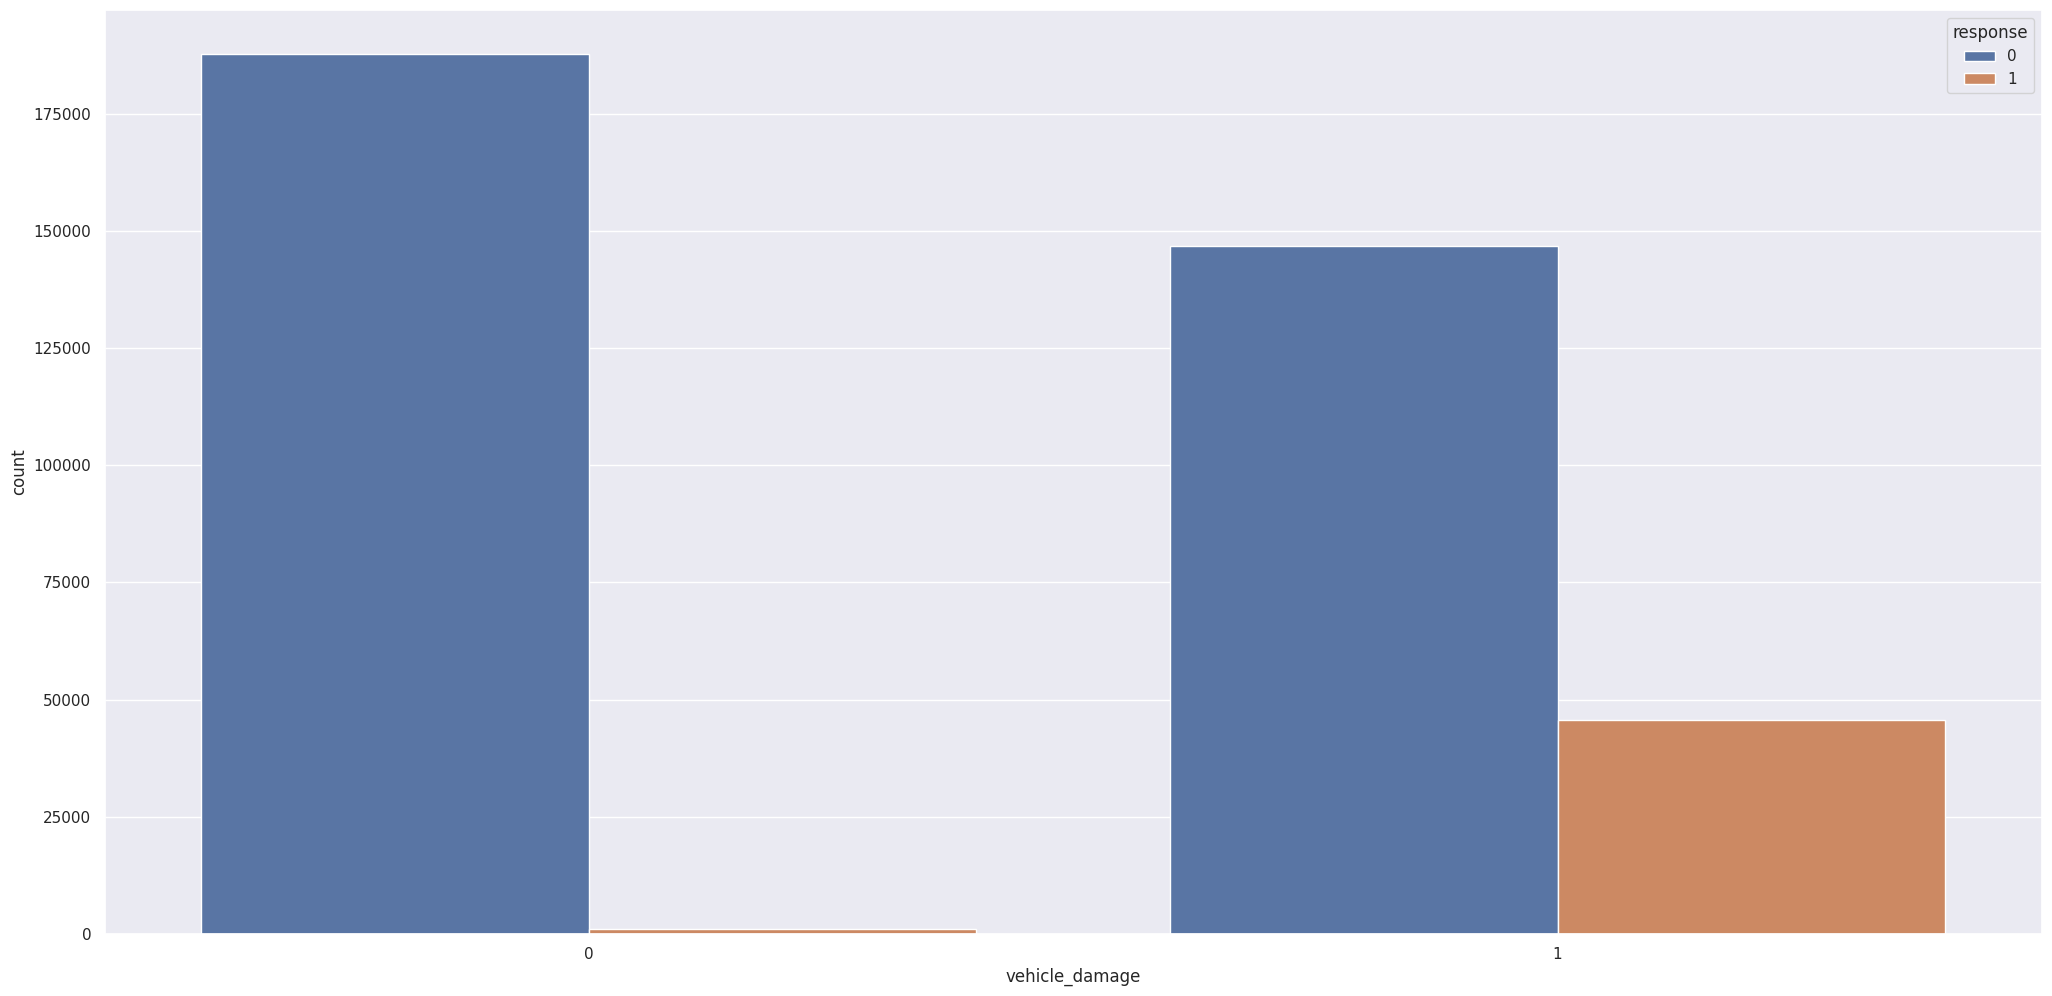

In [21]:
# 'vehicle_damage'
sns.countplot(x=df4['vehicle_damage'], hue=df4['response'])

pd.crosstab(df4['vehicle_damage'], df4['response']).apply(lambda x: x/x.sum(), axis=1)

### **H5.** Clientes com veículos mais novos são mais propensos a contratarem o seguro.
***FALSA.*** Clientes com veículos entre 1 e 2 anos são mais propensos a contratarem o seguro.

,vehicle_age,response,0
0,between_1_2_years,0,0.434285
1,below_1_year,0,0.413488
2,between_1_2_years,1,0.091328
3,over_2_years,0,0.029663
4,below_1_year,1,0.018897
5,over_2_years,1,0.012338


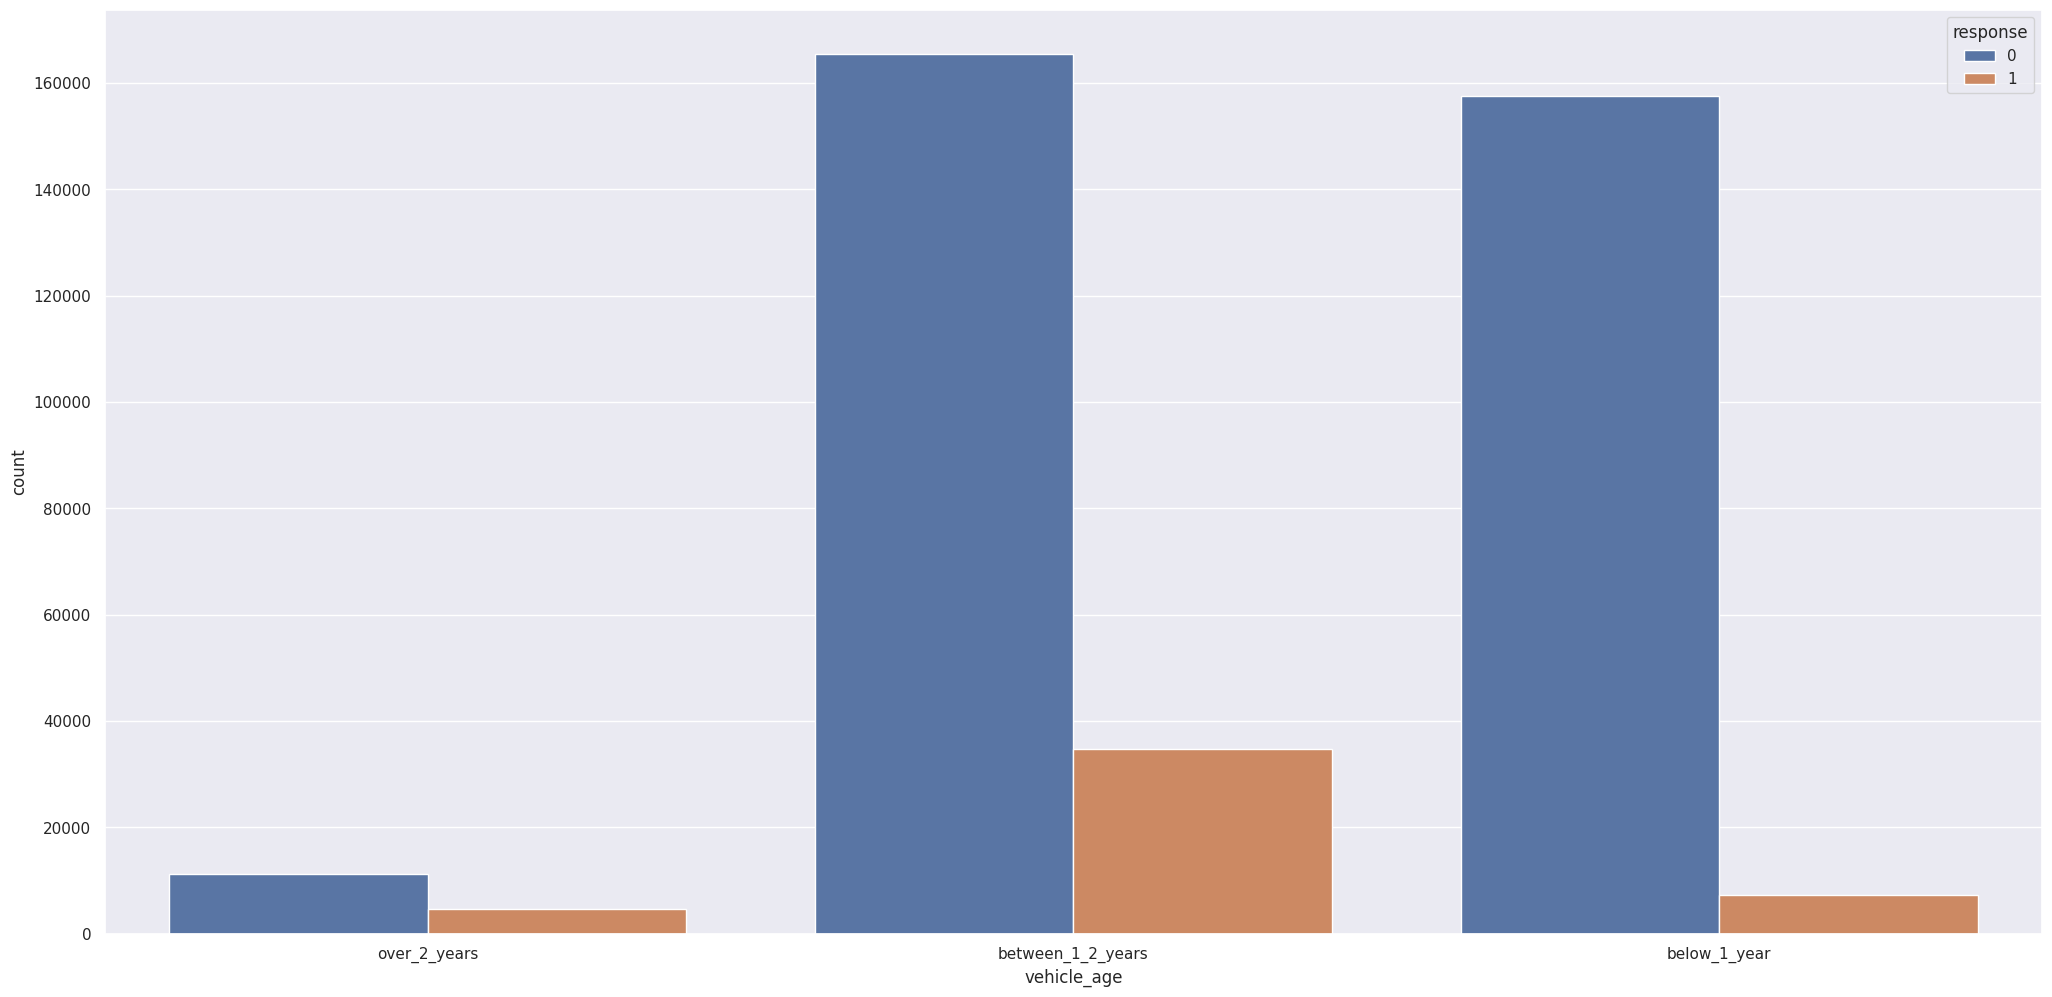

In [24]:
# 'vehicle_age'
sns.countplot(x=df4['vehicle_age'], hue=df4['response'])

df4[['vehicle_age', 'response']].value_counts(normalize=True).reset_index()

### **H6.** Clientes com planos mais caros são mais propensos a contratarem o seguro.
***FALSA.*** Clientes com planos em torno de 30000 (valores intermediários) rúpias são mais propensos a contratarem o seguro.

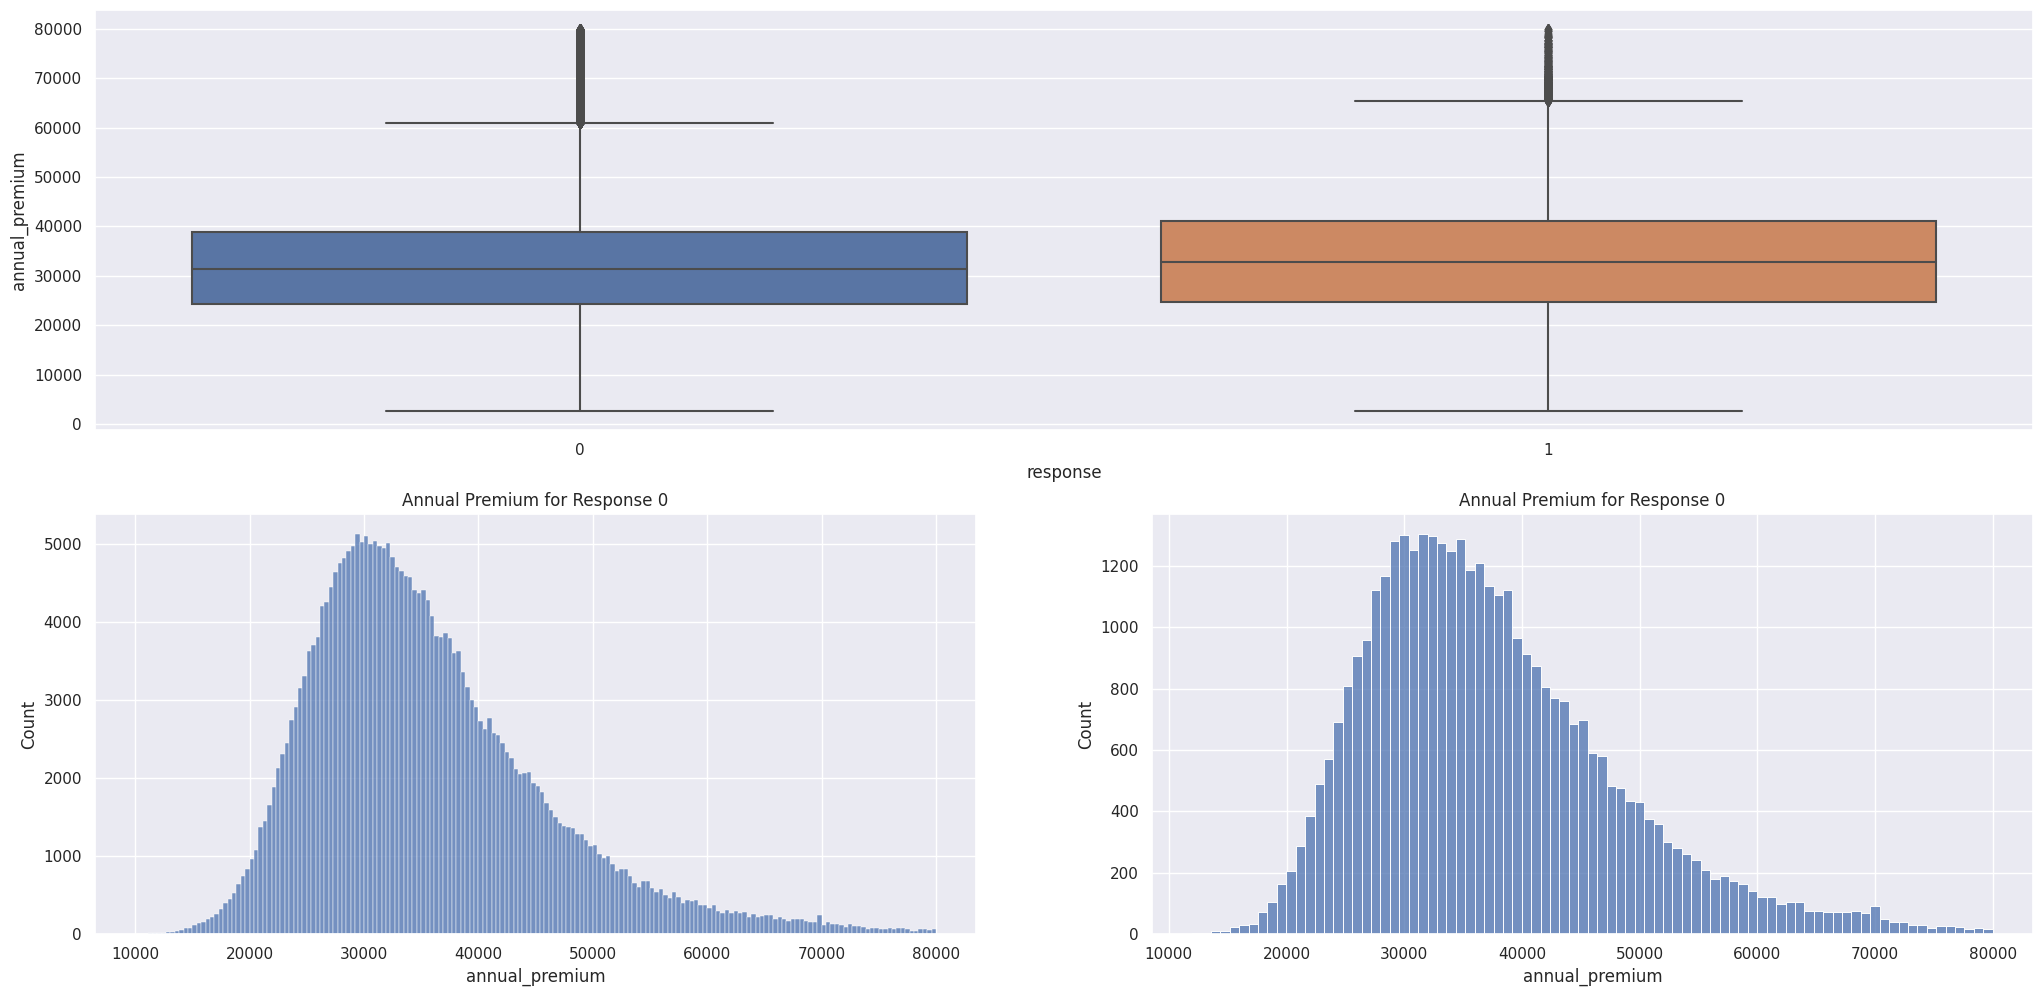

In [22]:
# 'annual_premium'
G = gridspec.GridSpec(2, 2)

aux = df4[df4['annual_premium'] < 80000]
ax1 = plt.subplot(G[0, :])
sns.boxplot(x='response', y='annual_premium', data=aux, ax=ax1)

# Removing outliers for better visualization
aux2 = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]

ax2 = plt.subplot(G[1, 0])
sns.histplot(data=aux2[aux2['response'] == 0], x='annual_premium', ax=ax2)
plt.title('Annual Premium for Response 0')

ax3 = plt.subplot(G[1, 1])
sns.histplot(data=aux2[aux2['response'] == 1], x='annual_premium', ax=ax3)
plt.title('Annual Premium for Response 1');

### **H7.** Clientes mais antigos são mais propensos a contratarem o seguro.
***FALSA.*** Clientes mais antigos não apresentam maior propensão que clientes novos.

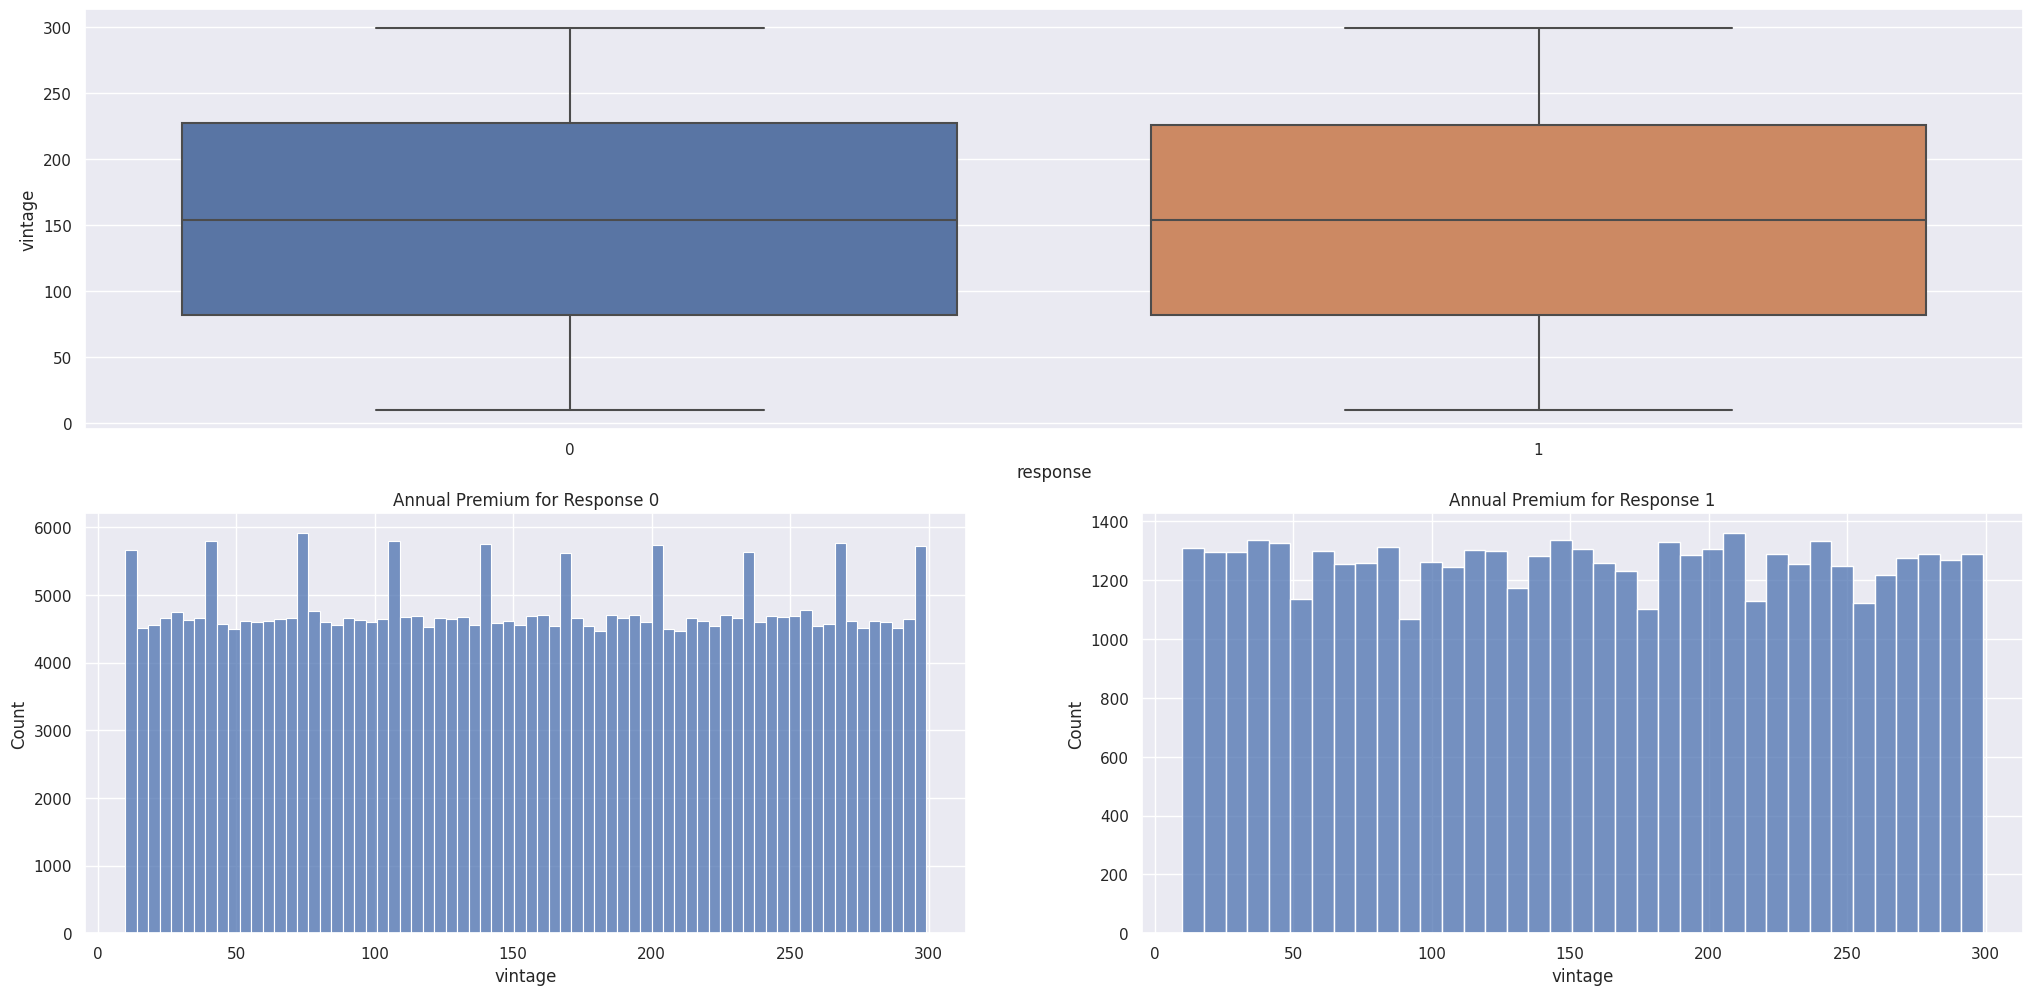

In [24]:
# 'vintage'
G = gridspec.GridSpec(2, 2)

ax1 = plt.subplot(G[0, :])
sns.boxplot(x=df4['response'], y=df4['vintage'])

ax2 = plt.subplot(G[1, 0])
sns.histplot(data=df4[df4['response'] == 0], x='vintage', ax=ax2)
plt.title('Annual Premium for Response 0')

ax3 = plt.subplot(G[1, 1])
sns.histplot(data=df4[df4['response'] == 1], x='vintage', ax=ax3)
plt.title('Annual Premium for Response 1');

### **H8.** Clientes contatados por um determinado meio de comunicação são mais propensos a contratarem o seguro.
***VERDADEIRA.*** Clientes contatados por determinados meios de comunicação sao mais propensos a contratarem o seguro.

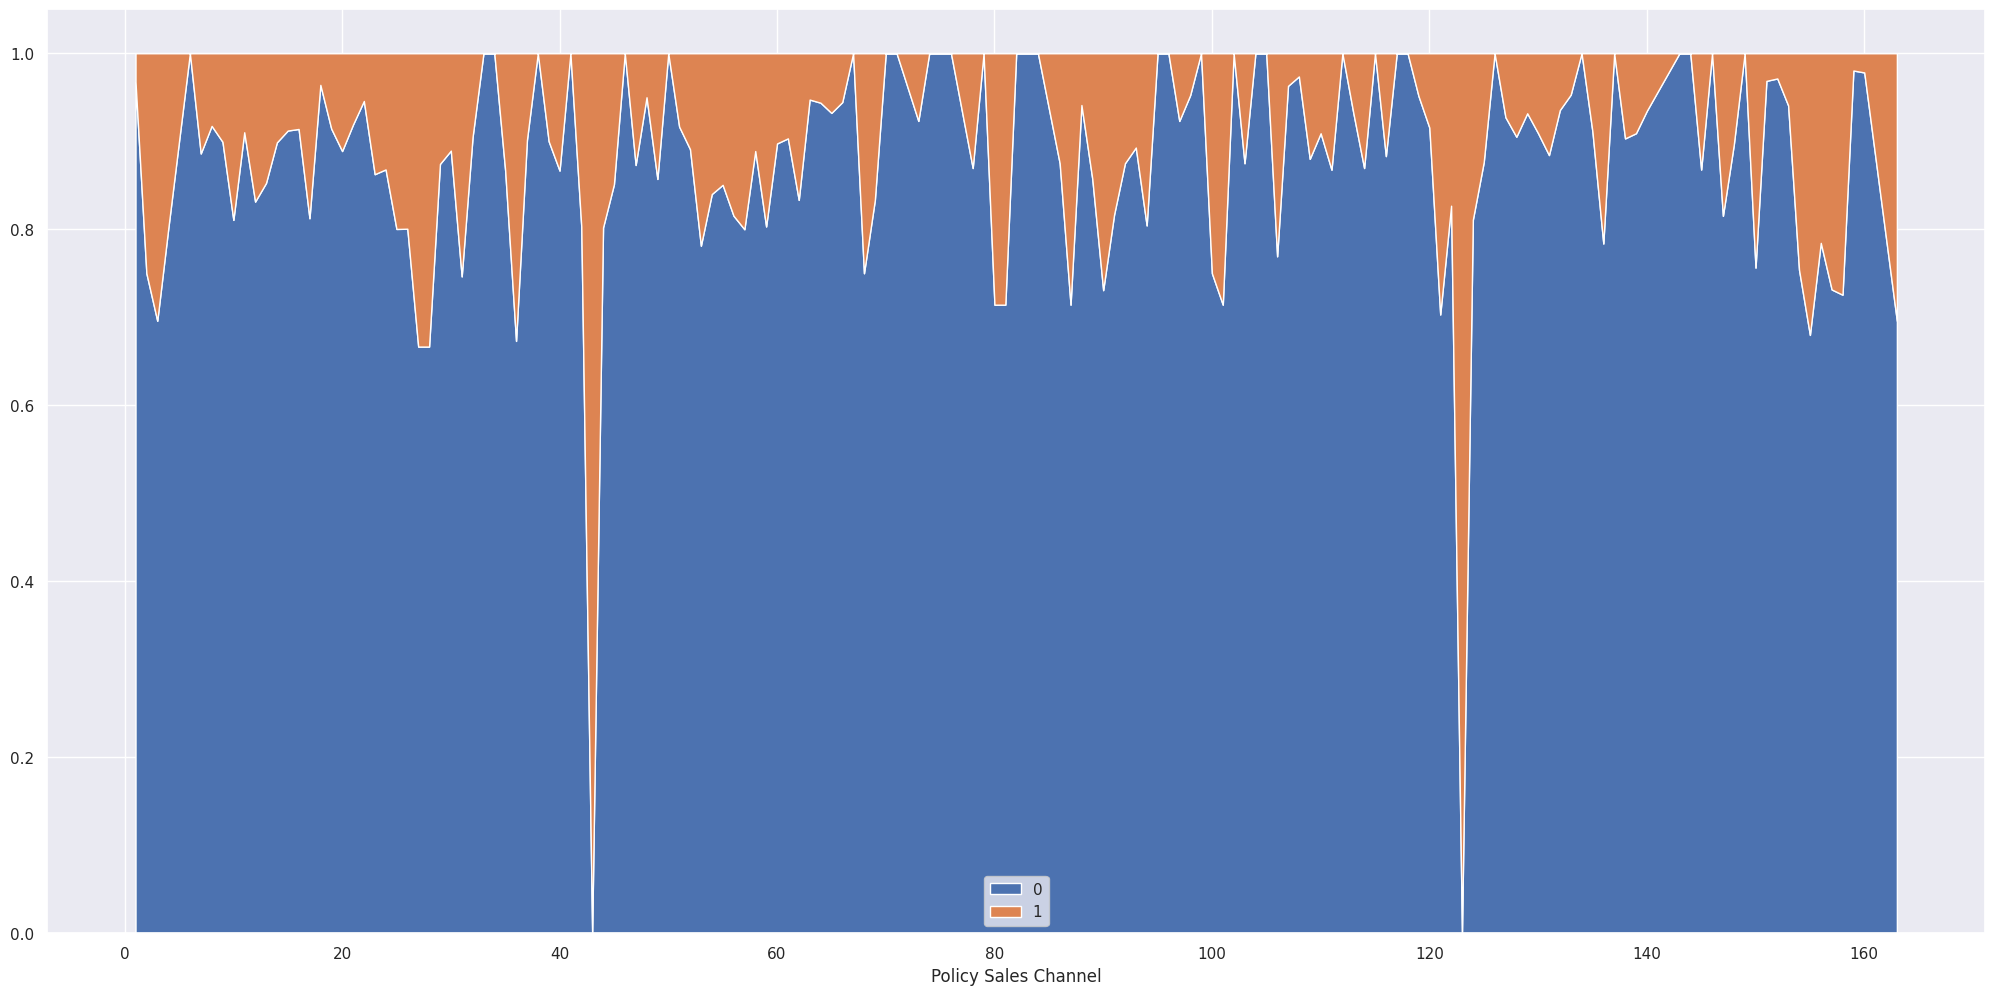

In [23]:
# 'policy_sales_channel'
aux1 = pd.crosstab(df4['policy_sales_channel'], df4['response']).apply(lambda x: x/x.sum(), axis=1).reset_index()

x = aux1['policy_sales_channel']
y1=aux1[0]
y2=aux1[1]

plt.stackplot(x, y1, y2, labels=['0', '1'])
plt.xlabel('Policy Sales Channel')
plt.legend(loc='lower center');

### **H9.** Clientes que já possuem seguro de veículo são menos propensos a contratarem o seguro.
***VERDADEIRA.*** Clientes que não possuem seguro de veículo são mais propensos a contratarem o seguro.

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


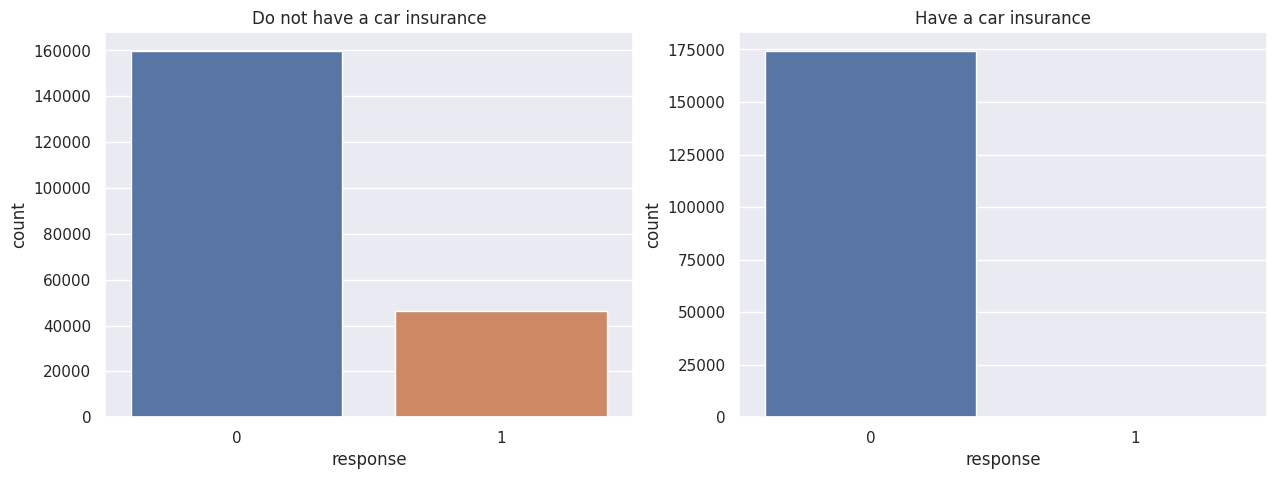

In [19]:
# 'previously_insured'
plt.figure(figsize=(15, 5))
G = gridspec.GridSpec(1, 2)

ax1 = plt.subplot(G[0, 0])
sns.countplot(x='response', data=df4[df4['previously_insured'] == 0], ax=ax1)
plt.title('Do not have a car insurance')

ax2 = plt.subplot(G[0, 1])
sns.countplot(x='response', data=df4[df4['previously_insured'] == 1], ax=ax2)
plt.title('Have a car insurance');

# percentage
pd.crosstab(df4['previously_insured'], df4['response']).apply(lambda x: x/x.sum(), axis=1)

### **H10.** Clientes que moram em regiões com maior taxa de acidentes são mais propensos a contratarem o seguro.
***INDETERMINADA.*** Uma região apresenta mais clientes propensos, mas é a região com mais clientes no total e não é possível saber a situação socioeconômica da região.

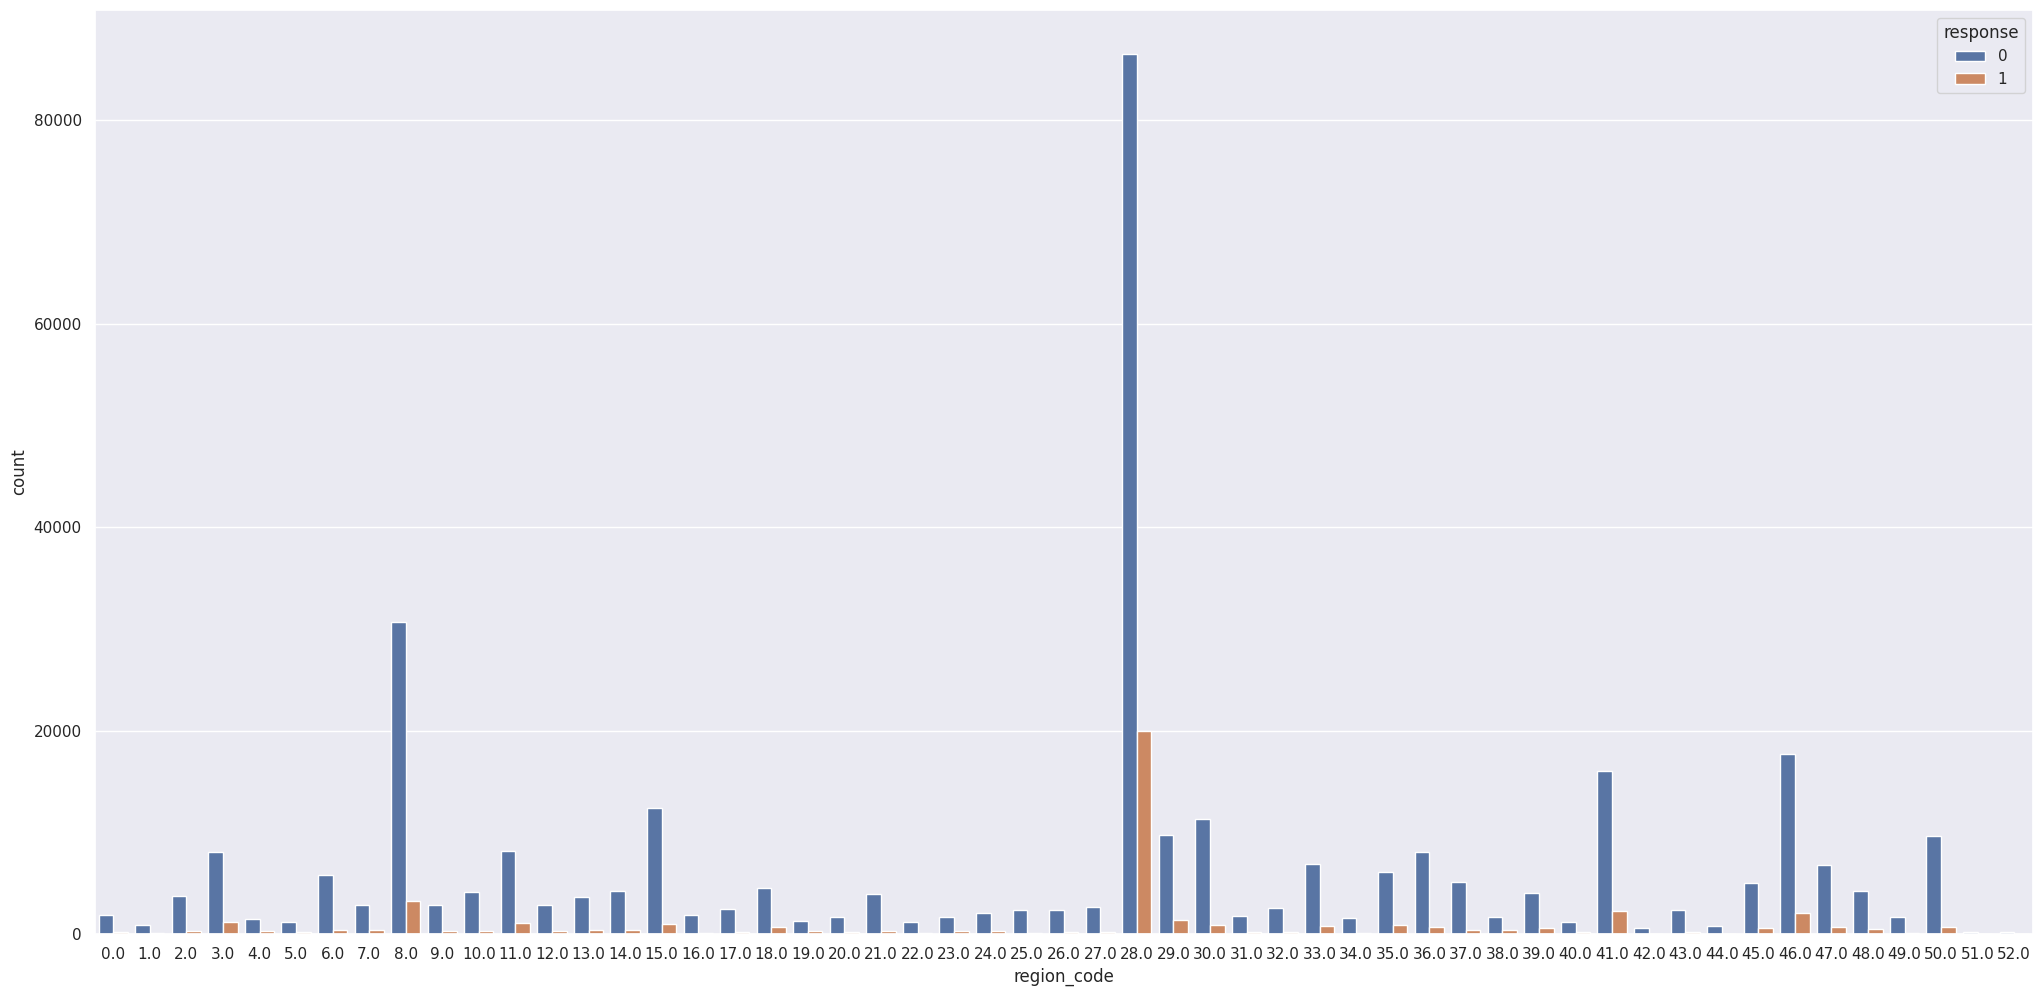

In [18]:
# 'region_code'
sns.countplot(x='region_code', hue='response', data=df4);

## 4.3 Resumo das Hipóteses

| Hipóteses | Conclusão | Relevância |
|-------|-------|-----|
H1| Verdadeira | Média
H2| Falsa | Baixa
H3| Verdadeira | Alta
H4| Verdadeira | Alta
H5| Falsa | Baixa
H6| Falsa | Baixa
H7| Falsa | Baixa
H8| Verdadeira | Alta
H9| Verdadeira | Alta
H10| Indeterminada | Alta


# 5.0 DATA PREPARATION

## 5.1 Data Split 

In [25]:
X = df4.drop('response', axis=1)
y = df4['response'].copy()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, stratify=y, random_state=50)

# Cross validation
X_train_cv = X_train.copy()
y_train_cv = y_train.copy()

## Standardization

In [26]:
ss = StandardScaler()

# annual_premium
X_train['annual_premium'] = ss.fit_transform(X_train[['annual_premium']].values)

## Rescaling

In [27]:
mms_age = MinMaxScaler()
mms_vintage = MinMaxScaler()

# age (since its distribution is not a normal one)
X_train['age'] = mms_age.fit_transform(X_train[['age']].values)

# vintage
X_train['vintage'] = mms_vintage.fit_transform(X_train[['vintage']].values)

## Encoder

In [28]:
# gender
le = LabelEncoder()
X_train['gender'] = le.fit_transform(X_train['gender'])


# region_code - Target Enconder
te = TargetEncoder()
X_train['region_code'] = X_train['region_code'].astype(str)
X_train['region_code'] = te.fit_transform(X_train['region_code'], y_train)


# vehicle_age - Ordinal Encoding
vehicle_age_dict = {'below_1_year': 1, 'between_1_2_years': 2, 'over_2_years': 3}
X_train['vehicle_age'] = X_train['vehicle_age'].map(vehicle_age_dict)


# policy_sales_channel - Frequency Encoding
X_train['policy_sales_channel'] = X_train['policy_sales_channel'].astype(str)
cfe = CountFrequencyEncoder(encoding_method='frequency', variables=['policy_sales_channel'])
X_train = cfe.fit_transform(X_train)

/home/matheus/.pyenv/versions/3.8.12/envs/pa004/lib/python3.8/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/home/matheus/.pyenv/versions/3.8.12/envs/pa004/lib/python3.8/site-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


## Validation Encoding

In [29]:
# annual_premium
X_val['annual_premium'] = ss.transform(X_val[['annual_premium']].values)

# age (since its distribution is not a normal one)
X_val['age'] = mms_age.transform(X_val[['age']].values)

# vintage
X_val['vintage'] = mms_vintage.transform(X_val[['vintage']].values)

# gender
X_val['gender'] = le.transform(X_val['gender'])

# region_code - Target Enconder
X_val['region_code'] = X_val['region_code'].astype(str)
X_val['region_code'] = te.transform(X_val['region_code'])

# vehicle_age - Ordinal Encoding
vehicle_age_dict = {'below_1_year': 1, 'between_1_2_years': 2, 'over_2_years': 3}
X_val['vehicle_age'] = X_val['vehicle_age'].map(vehicle_age_dict)

# policy_sales_channel - Frequency Encoding
X_val['policy_sales_channel'] = X_val['policy_sales_channel'].astype(str)
X_val = cfe.transform(X_val)
X_val = X_val.replace(np.nan, 0)

/home/matheus/.pyenv/versions/3.8.12/envs/pa004/lib/python3.8/site-packages/feature_engine/encoding/base_encoder.py:210: UserWarning: During the encoding, NaN values were introduced in the feature(s) policy_sales_channel.
  warnings.warn(


# 6.0 FEATURE SELECTION

## 6.1 Boruta Selection

In [34]:
# training and test dataset for Boruta
X_train_b = X_train.drop(['id', 'region_code'], axis=1).values
y_train_b = y_train.values.ravel()

# define RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

# define Boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_b, y_train_b)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	8
Iteration: 	9 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	8
Iteration: 	10 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	8
Iteration: 	11 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	8
Iteration: 	12 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	8
Iteration: 	13 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	8
Iteration: 	14 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	8
Iteration: 	15 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	8
Iteration: 	16 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	8
Iteration:

In [36]:
cols_selected = boruta.support_.tolist()

# best features
X_train_fs = X_train.drop(['id', 'region_code'], axis=1)
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = np.setdiff1d(X_train_fs.columns, cols_selected_boruta)

In [42]:
print(f'Cols selected:{cols_selected_boruta}')
print(f'Cols not selected: {cols_not_selected_boruta}')

Cols selected:['vehicle_damage']
Cols not selected: ['age' 'annual_premium' 'driving_license' 'gender' 'policy_sales_channel'
 'previously_insured' 'region_code_encoded' 'vehicle_age' 'vintage']


## 6.2 Features Importance

In [45]:
# Model
forest = ExtraTreesClassifier(n_estimators=250, n_jobs=-1)

# data preparation
X_train_n = X_train.drop(['id', 'region_code'], axis=1)
y_train_n = y_train.values

forest.fit(X_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1)

In [46]:
# Print the feature ranking
print('Features ranking:')
df = pd.DataFrame()

for i, j in zip(X_train_n, forest.feature_importances_):
    aux = pd.DataFrame({'feature':i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis=0)
    
print(df.sort_values('importance', ascending=False))

Features ranking:
                feature  importance
0               vintage    0.278095
0        annual_premium    0.246704
0                   age    0.157871
0   region_code_encoded    0.105943
0        vehicle_damage    0.071834
0  policy_sales_channel    0.060828
0    previously_insured    0.056785
0           vehicle_age    0.016155
0                gender    0.005294
0       driving_license    0.000489


In [30]:
cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage',
                 'policy_sales_channel', 'previously_insured']

# 7.0 MACHINE LEARNING

In [31]:
x_train = X_train[cols_selected]
x_val = X_val[cols_selected]

In [33]:
df7 = X_val.copy()
df7['response'] = y_val.copy()

## 7.1 Models

### K-Nearest Neighbors

In [34]:
# Model
knn_model = KNeighborsClassifier(n_neighbors=10)

# model training
knn_model.fit(x_train, y_train)

# model prediction - GENERALIZATION
yhat_knn = knn_model.predict_proba(x_val)

<AxesSubplot: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

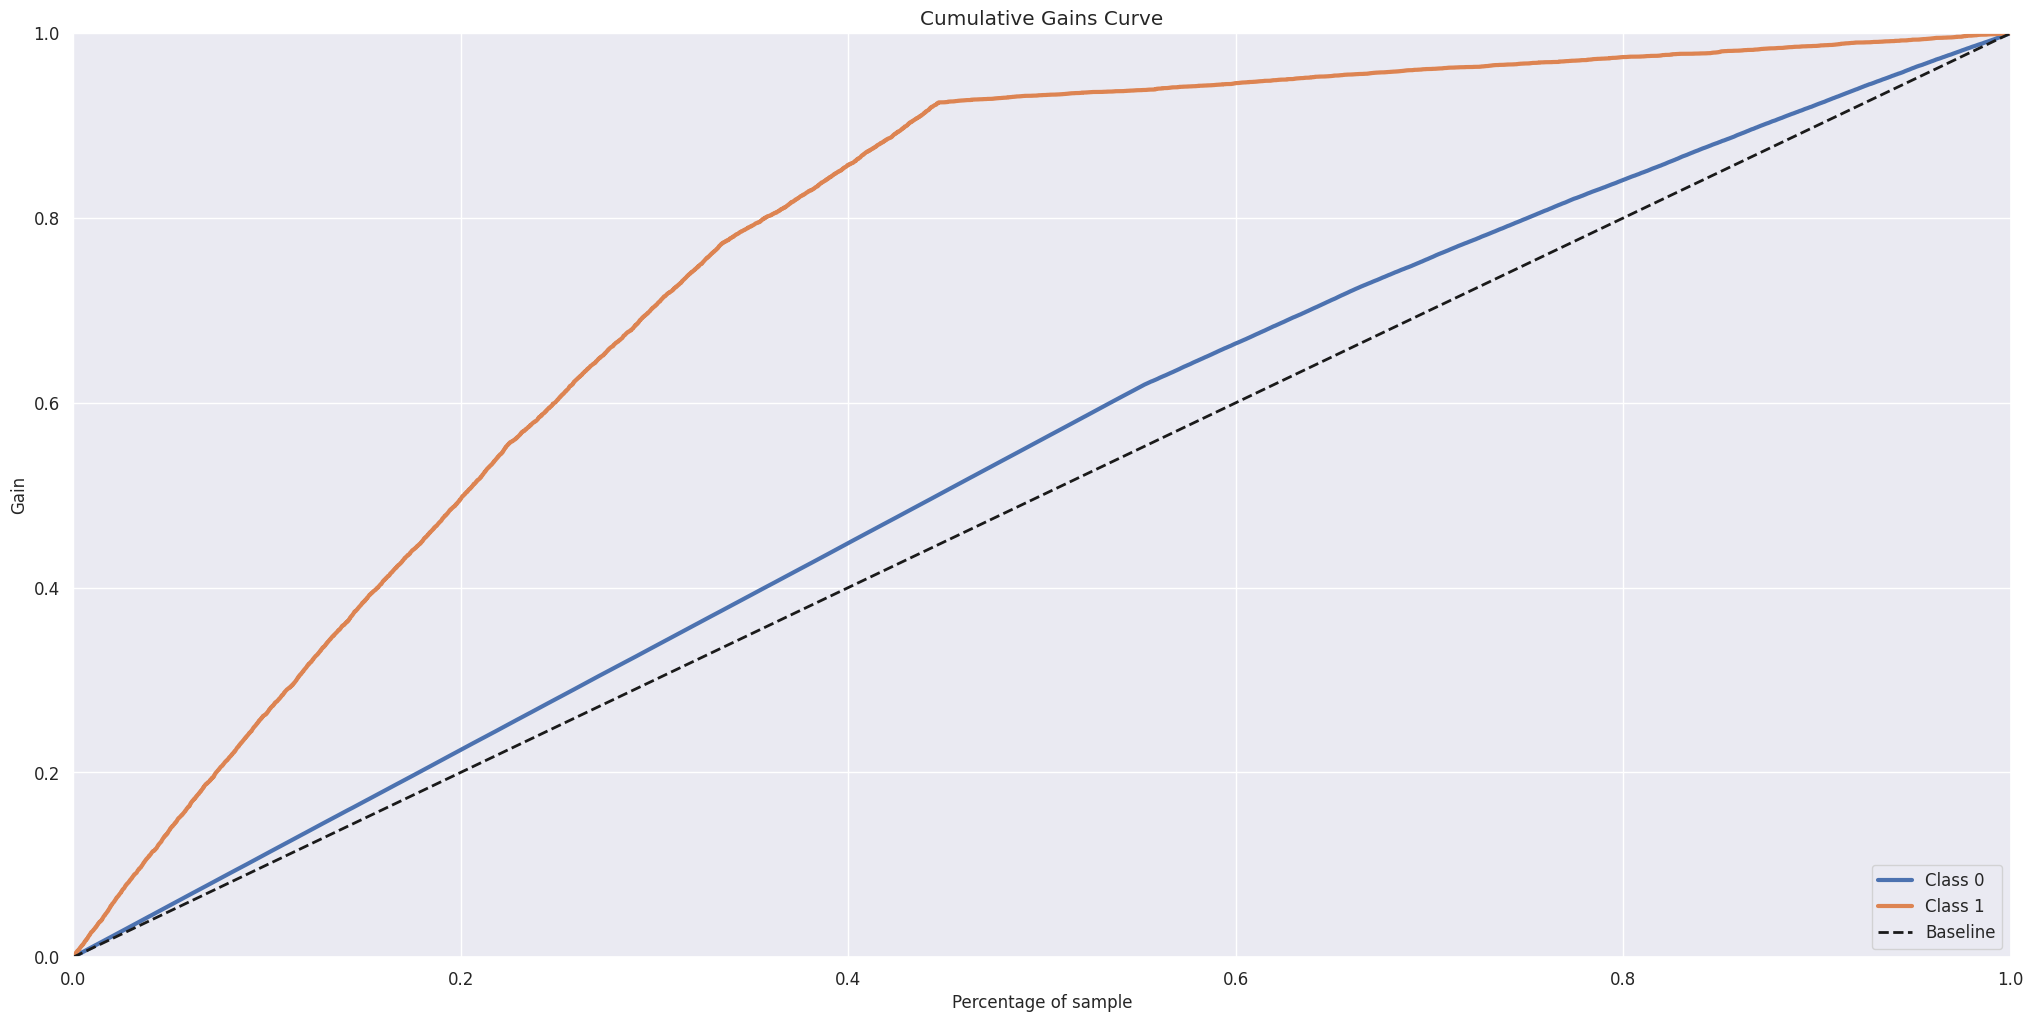

In [35]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn)

In [36]:
print(f'Precision at k: {precision_at_k(df8, yhat_knn)}')
print(f'Recall at k: {recall_at_k(df8, yhat_knn)}')

Precision at k: 0.2934353282335883
Recall at k: 0.6282380646542496


#### Cross Validation

In [62]:
cv_knn = cross_validation(knn_model, 5, X_train_cv, y_train_cv)

/tmp/ipykernel_9484/1276913504.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_9484/1276913504.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_9484/1276913504.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

/tmp/ipykernel_9484/1276913504.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
/tmp/ipykernel_9484/1276913504.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_9484/1276913504.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

/tmp/ipykernel_9484/1276913504.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_9484/1276913504.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['age'] = mms_age.transform(X_test_fold[['age']].values)
/tmp/ipykernel_9484/1276913504.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/ipykernel_9484/1276913504.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_9484/1276913504.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_9484/1276913504.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

### Logistic Regression

In [47]:
# Model
lr_model = LogisticRegression()

# model training
lr_model.fit(x_train, y_train)

# model prediction - GENERALIZATION
yhat_lr = lr_model.predict_proba(x_val)

<AxesSubplot: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

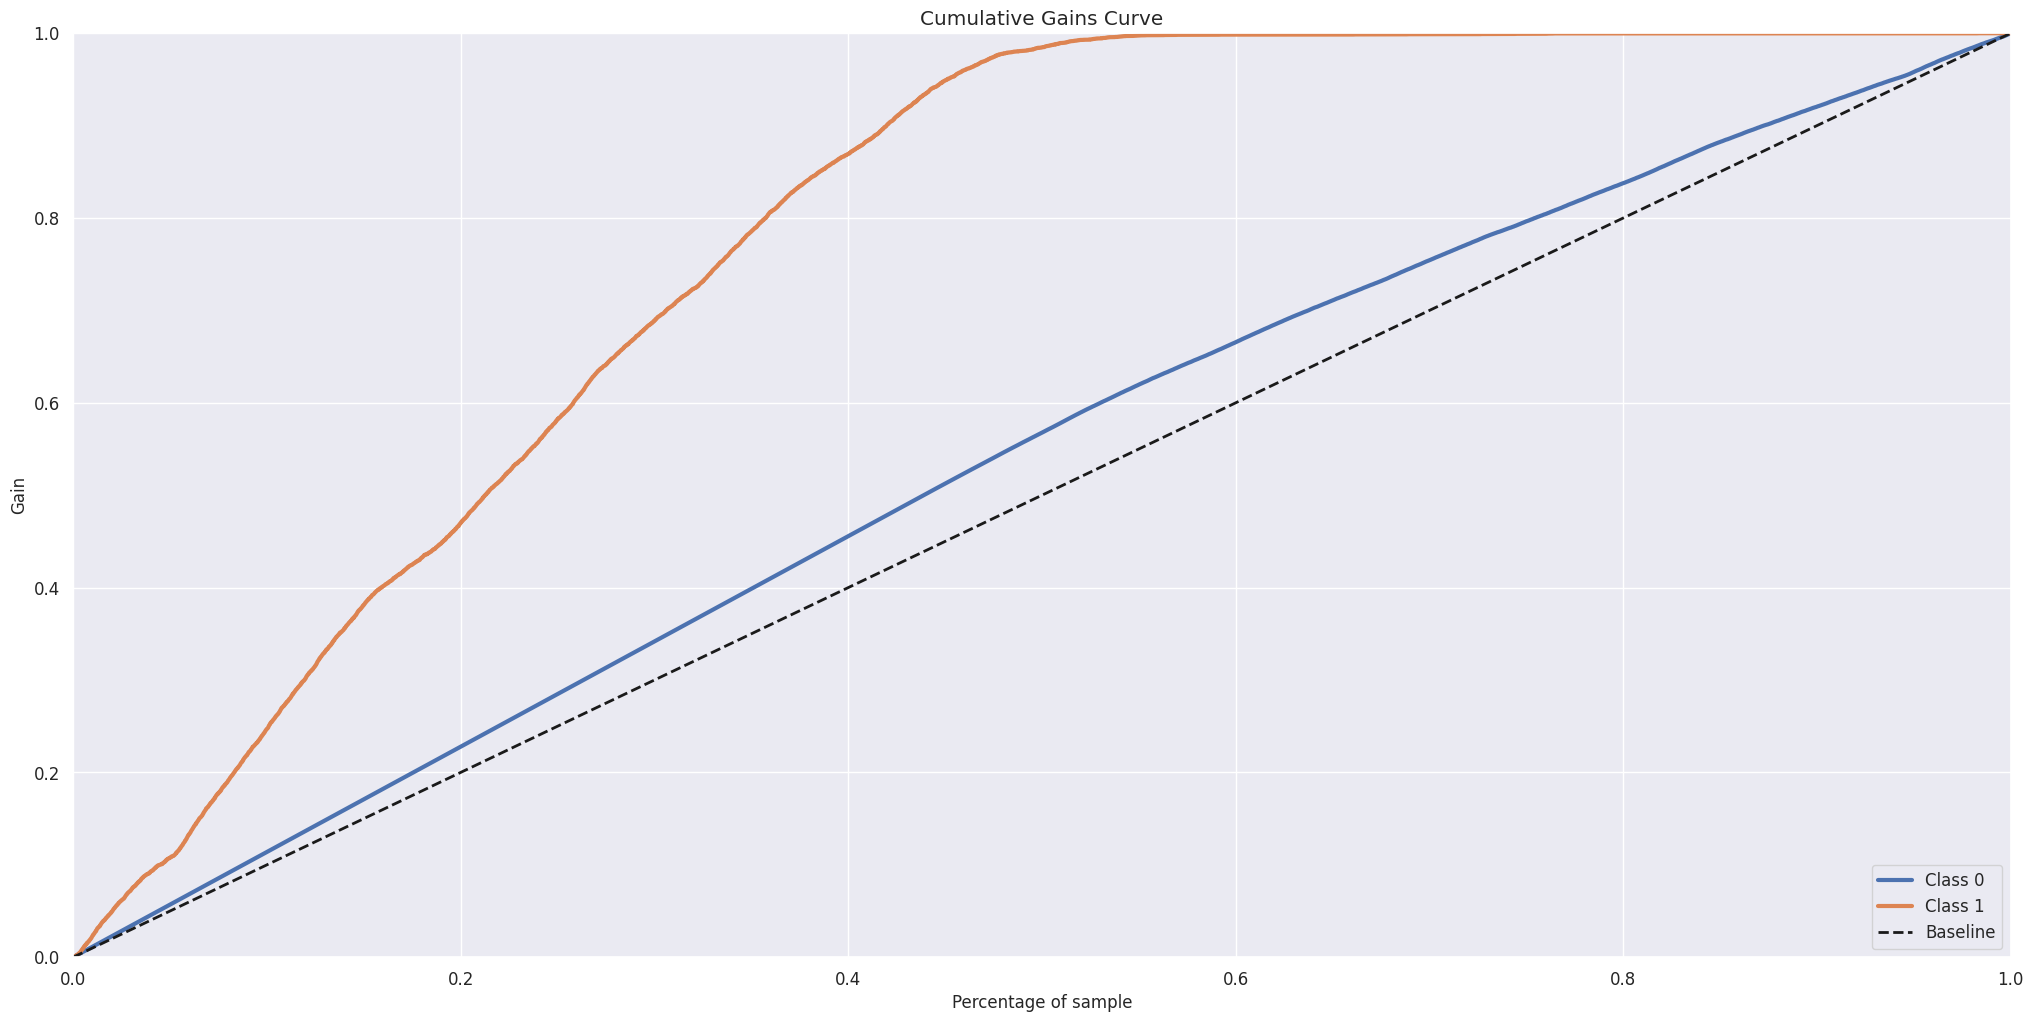

In [48]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_lr)

In [49]:
print(f'Precision at k: {precision_at_k(df8, yhat_lr)}')
print(f'Recall at k: {recall_at_k(df8, yhat_lr)}')

Precision at k: 0.2855357232138393
Recall at k: 0.6113251980304003


#### Cross Validation

In [50]:
cv_lr = cross_validation(lr_model, 5, X_train_cv, y_train_cv)
cv_lr

/tmp/ipykernel_9484/1276913504.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_9484/1276913504.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_9484/1276913504.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

/tmp/ipykernel_9484/1276913504.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
/tmp/ipykernel_9484/1276913504.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_9484/1276913504.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

/tmp/ipykernel_9484/1276913504.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_9484/1276913504.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['age'] = mms_age.transform(X_test_fold[['age']].values)
/tmp/ipykernel_9484/1276913504.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/ipykernel_9484/1276913504.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['policy_sales_channel'] = X_test_fold['policy_sales_channel'].astype(str)
/home/matheus/.pyenv/versions/3.8.12/envs/pa004/lib/python3.8/site-packages/feature_engine/encoding/base_encoder.py:210: UserWarning: During the encoding, NaN values were introduced in the feature(s) policy_sales_channel.
  warnings.warn(
/tmp/ipykernel_9484/1276913504.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annu

,Model,Precision at k,Recall at k
0,LogisticRegression,0.2753+/-0.0019,0.7368+/-0.0052


### Random Forest

In [51]:
# Model
rf_model = RandomForestClassifier(n_jobs=-1)

# model training
rf_model.fit(x_train, y_train)

# model prediction - GENERALIZATION
yhat_rf = lr_model.predict_proba(x_val)

<AxesSubplot: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

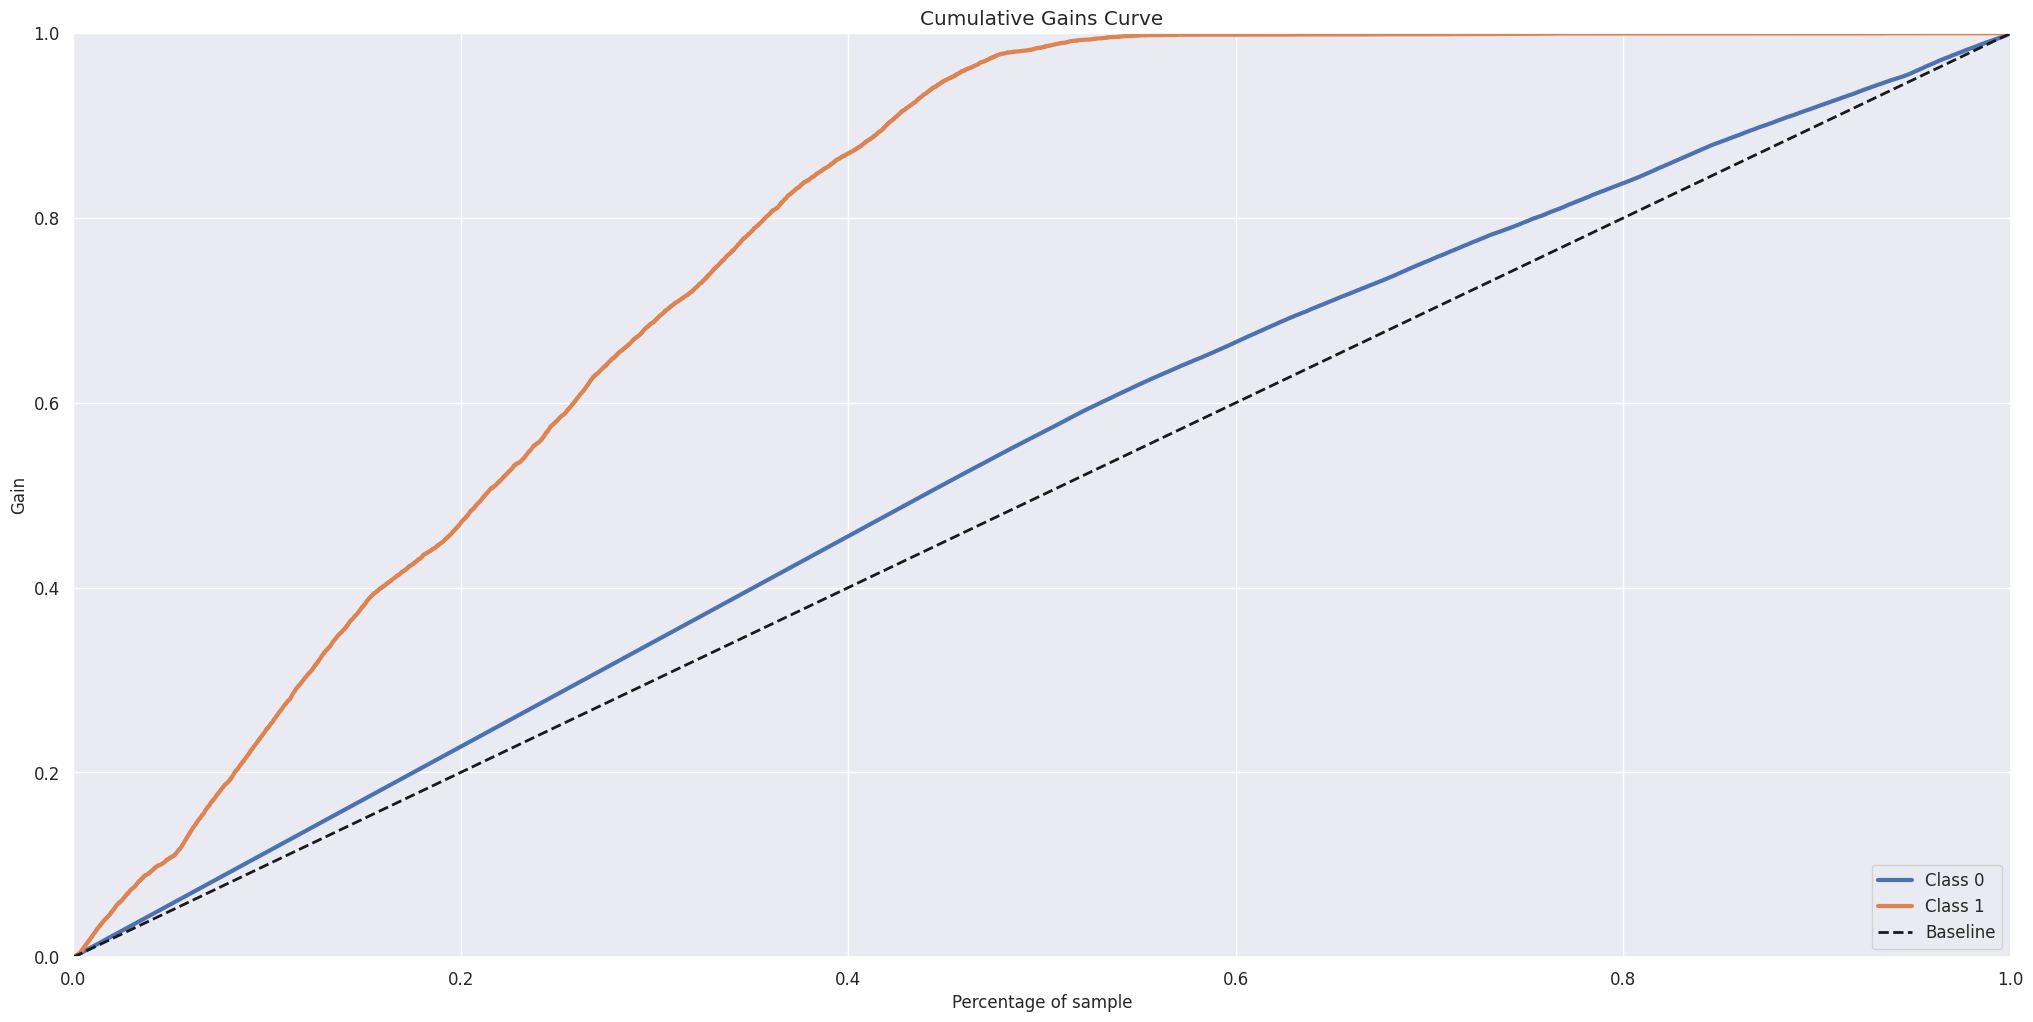

In [52]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_rf)

In [53]:
print(f'Precision at k: {precision_at_k(df8, yhat_rf)}')
print(f'Recall at k: {recall_at_k(df8, yhat_rf)}')

Precision at k: 0.2851857407129644
Recall at k: 0.610575893812888


#### Cross Validation

In [54]:
cv_rf = cross_validation(rf_model, 5, X_train_cv, y_train_cv)
cv_rf

/tmp/ipykernel_9484/1276913504.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_9484/1276913504.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_9484/1276913504.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

/tmp/ipykernel_9484/1276913504.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
/tmp/ipykernel_9484/1276913504.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_9484/1276913504.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

/tmp/ipykernel_9484/1276913504.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_9484/1276913504.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['age'] = mms_age.transform(X_test_fold[['age']].values)
/tmp/ipykernel_9484/1276913504.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/ipykernel_9484/1276913504.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_9484/1276913504.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_9484/1276913504.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

,Model,Precision at k,Recall at k
0,RandomForestClassifier,0.2914+/-0.0012,0.7798+/-0.0031


### XGBoost

In [55]:
# Model
xgb_model = XGBClassifier(max_delta_step=1, n_jobs=-1)

# model training
xgb_model.fit(x_train, y_train)

# model prediction
yhat_xgb = xgb_model.predict_proba(x_val)

<AxesSubplot: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

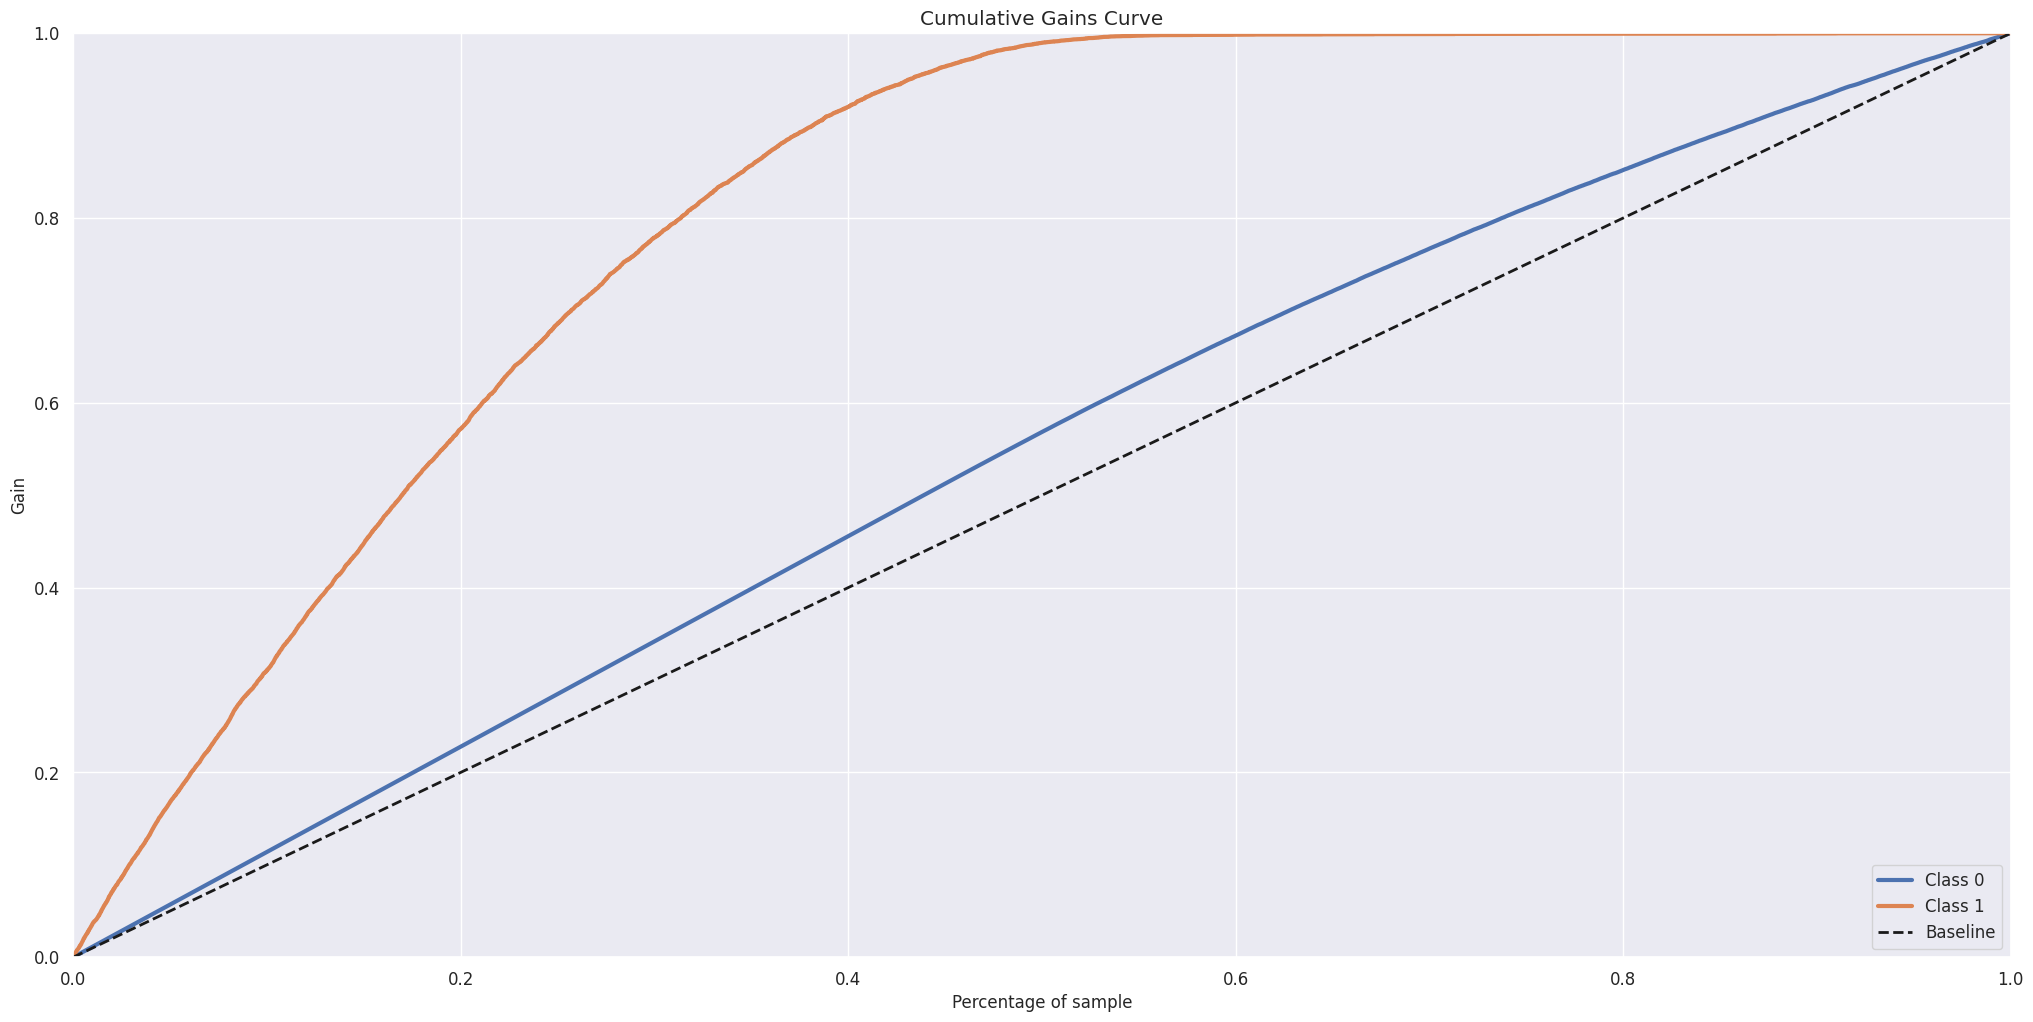

In [56]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_xgb)

In [57]:
print(f'Precision at k: {precision_at_k(df8, yhat_xgb)}')
print(f'Recall at k: {recall_at_k(df8, yhat_xgb)}')

Precision at k: 0.33173341332933354
Recall at k: 0.7102333547420253


#### Cross Validation

In [63]:
cv_xgb = cross_validation(xgb_model, 5, X_train_cv, y_train_cv)

/tmp/ipykernel_9484/1276913504.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_9484/1276913504.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_9484/1276913504.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

/tmp/ipykernel_9484/1276913504.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_9484/1276913504.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['vehicle_age'] = X_train_fold['vehicle_age'].map(vehicle_age_dict)
/tmp/ipykernel_9484/1276913504.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

/tmp/ipykernel_9484/1276913504.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_9484/1276913504.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['age'] = mms_age.transform(X_test_fold[['age']].values)
/tmp/ipykernel_9484/1276913504.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/ipykernel_9484/1276913504.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_9484/1276913504.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_9484/1276913504.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

### LightGBM

In [58]:
# Model
lgbm_model = LGBMClassifier()

# model training
lgbm_model.fit(x_train, y_train)

# model prediction
yhat_lgbm = lgbm_model.predict_proba(x_val)

<AxesSubplot: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

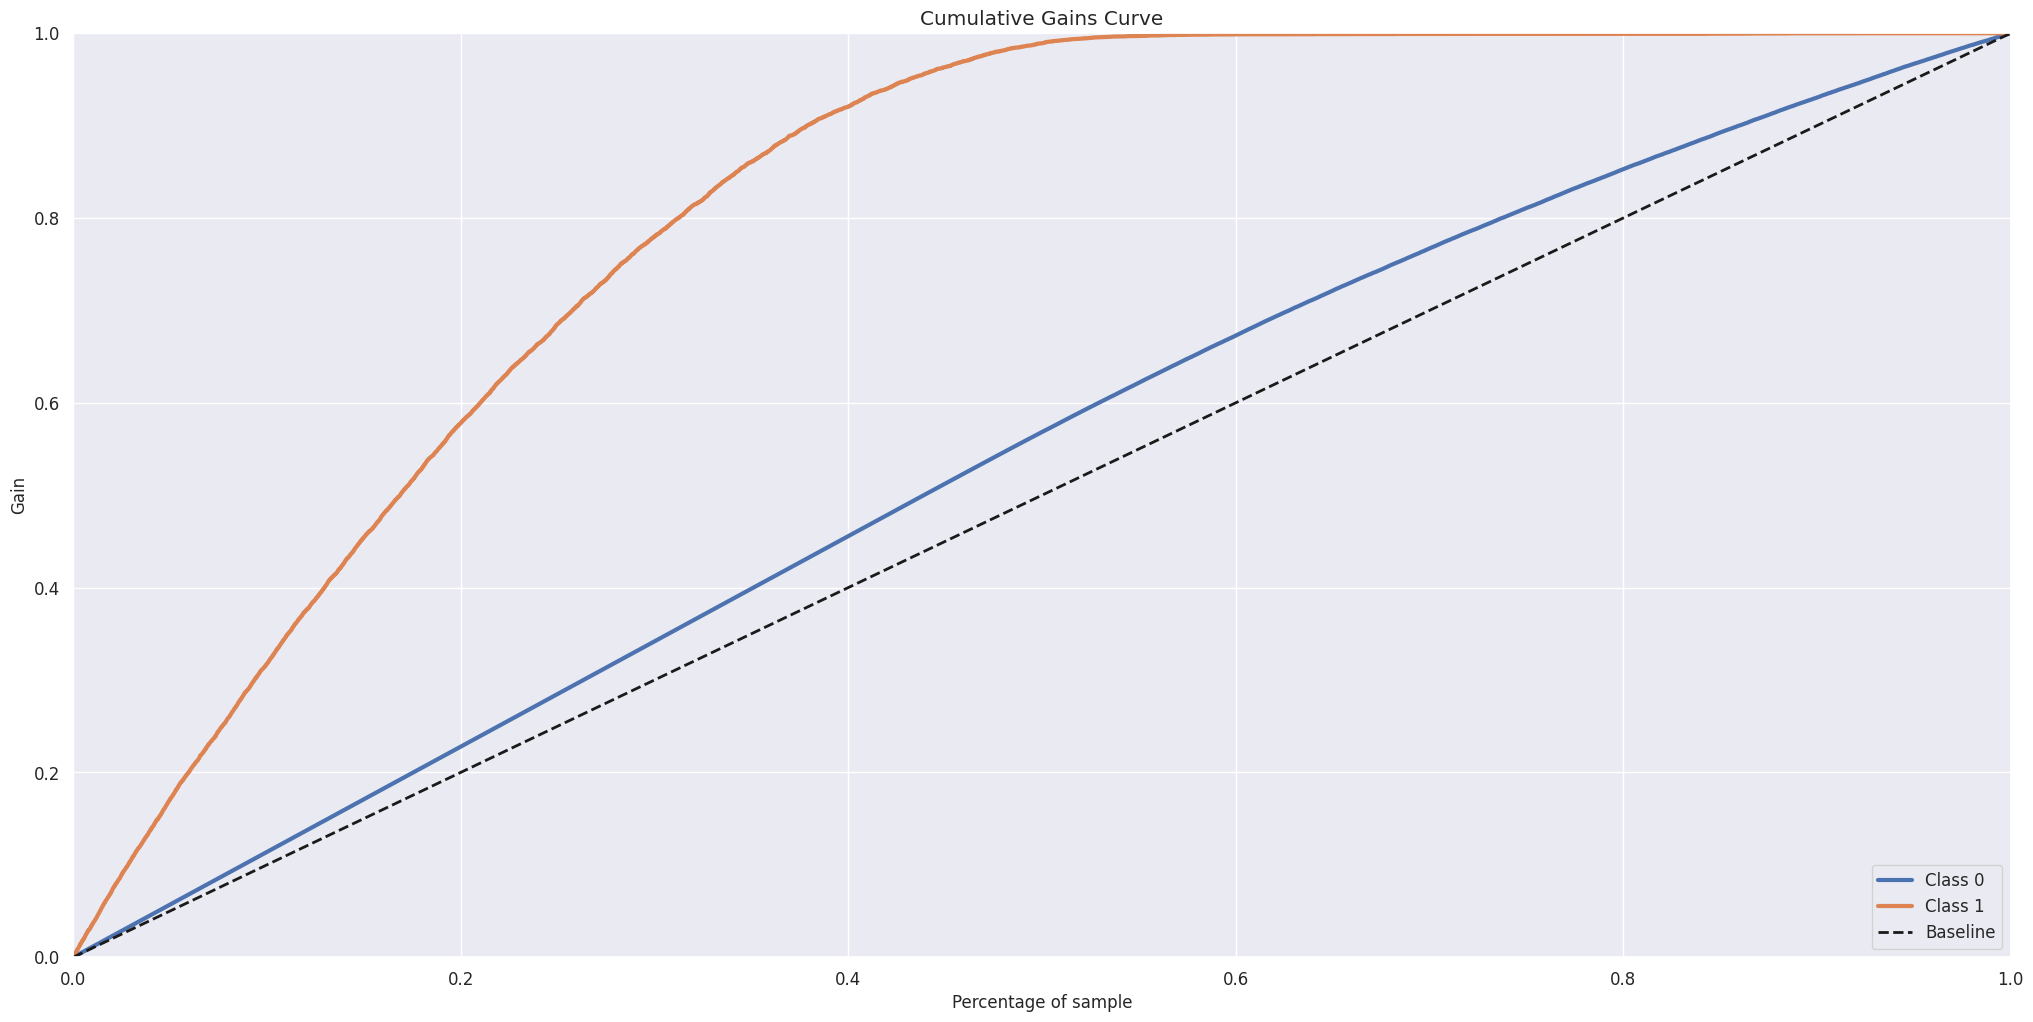

In [59]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_lgbm)

In [60]:
print(f'Precision at k: {precision_at_k(df8, yhat_lgbm)}')
print(f'Recall at k: {recall_at_k(df8, yhat_lgbm)}')

Precision at k: 0.3317834108294585
Recall at k: 0.7103403982016698


#### Cross Validation

In [64]:
cv_lgbm = cross_validation(lgbm_model, 5, X_train_cv, y_train_cv)

/tmp/ipykernel_9484/1276913504.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_9484/1276913504.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_9484/1276913504.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

/tmp/ipykernel_9484/1276913504.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
/tmp/ipykernel_9484/1276913504.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_9484/1276913504.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

/tmp/ipykernel_9484/1276913504.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_9484/1276913504.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['age'] = mms_age.transform(X_test_fold[['age']].values)
/tmp/ipykernel_9484/1276913504.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/ipykernel_9484/1276913504.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_9484/1276913504.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_9484/1276913504.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

### CatBoost

In [65]:
# Model
cat_model = CatBoostClassifier()

# model training
cat_model.fit(x_train, y_train)

# model prediction
yhat_cat = cat_model.predict_proba(x_val)

Learning rate set to 0.118484
0:	learn: 0.5027261	total: 143ms	remaining: 2m 22s
1:	learn: 0.4030635	total: 216ms	remaining: 1m 47s
2:	learn: 0.3522607	total: 280ms	remaining: 1m 33s
3:	learn: 0.3243880	total: 380ms	remaining: 1m 34s
4:	learn: 0.3088864	total: 438ms	remaining: 1m 27s
5:	learn: 0.2973520	total: 512ms	remaining: 1m 24s
6:	learn: 0.2897217	total: 572ms	remaining: 1m 21s
7:	learn: 0.2844850	total: 639ms	remaining: 1m 19s
8:	learn: 0.2808386	total: 705ms	remaining: 1m 17s
9:	learn: 0.2786804	total: 750ms	remaining: 1m 14s
10:	learn: 0.2764507	total: 838ms	remaining: 1m 15s
11:	learn: 0.2748751	total: 931ms	remaining: 1m 16s
12:	learn: 0.2735378	total: 1s	remaining: 1m 15s
13:	learn: 0.2723812	total: 1.07s	remaining: 1m 15s
14:	learn: 0.2713744	total: 1.15s	remaining: 1m 15s
15:	learn: 0.2707721	total: 1.21s	remaining: 1m 14s
16:	learn: 0.2702400	total: 1.28s	remaining: 1m 14s
17:	learn: 0.2698440	total: 1.37s	remaining: 1m 14s
18:	learn: 0.2695632	total: 1.46s	remaining: 1m

162:	learn: 0.2633356	total: 11.4s	remaining: 58.4s
163:	learn: 0.2633193	total: 11.4s	remaining: 58.3s
164:	learn: 0.2633083	total: 11.5s	remaining: 58.2s
165:	learn: 0.2632883	total: 11.5s	remaining: 58s
166:	learn: 0.2632628	total: 11.6s	remaining: 57.9s
167:	learn: 0.2632425	total: 11.7s	remaining: 57.7s
168:	learn: 0.2632243	total: 11.7s	remaining: 57.6s
169:	learn: 0.2632063	total: 11.8s	remaining: 57.4s
170:	learn: 0.2631762	total: 11.8s	remaining: 57.3s
171:	learn: 0.2631540	total: 11.9s	remaining: 57.1s
172:	learn: 0.2631329	total: 11.9s	remaining: 57s
173:	learn: 0.2631198	total: 12s	remaining: 56.8s
174:	learn: 0.2631054	total: 12s	remaining: 56.8s
175:	learn: 0.2630835	total: 12.1s	remaining: 56.8s
176:	learn: 0.2630672	total: 12.2s	remaining: 56.7s
177:	learn: 0.2630534	total: 12.3s	remaining: 56.6s
178:	learn: 0.2630283	total: 12.3s	remaining: 56.5s
179:	learn: 0.2630064	total: 12.4s	remaining: 56.4s
180:	learn: 0.2629791	total: 12.4s	remaining: 56.3s
181:	learn: 0.262953

322:	learn: 0.2607424	total: 21.6s	remaining: 45.2s
323:	learn: 0.2607333	total: 21.6s	remaining: 45.2s
324:	learn: 0.2607102	total: 21.7s	remaining: 45.1s
325:	learn: 0.2606907	total: 21.8s	remaining: 45s
326:	learn: 0.2606745	total: 21.9s	remaining: 45s
327:	learn: 0.2606630	total: 21.9s	remaining: 44.9s
328:	learn: 0.2606436	total: 22s	remaining: 44.9s
329:	learn: 0.2606371	total: 22.1s	remaining: 44.8s
330:	learn: 0.2606259	total: 22.1s	remaining: 44.7s
331:	learn: 0.2606046	total: 22.2s	remaining: 44.7s
332:	learn: 0.2605895	total: 22.3s	remaining: 44.6s
333:	learn: 0.2605728	total: 22.3s	remaining: 44.5s
334:	learn: 0.2605653	total: 22.4s	remaining: 44.4s
335:	learn: 0.2605473	total: 22.4s	remaining: 44.3s
336:	learn: 0.2605326	total: 22.5s	remaining: 44.2s
337:	learn: 0.2605142	total: 22.5s	remaining: 44.1s
338:	learn: 0.2605051	total: 22.6s	remaining: 44s
339:	learn: 0.2604961	total: 22.7s	remaining: 44s
340:	learn: 0.2604762	total: 22.8s	remaining: 44s
341:	learn: 0.2604673	to

481:	learn: 0.2586217	total: 31.9s	remaining: 34.3s
482:	learn: 0.2586139	total: 32s	remaining: 34.3s
483:	learn: 0.2585960	total: 32.1s	remaining: 34.2s
484:	learn: 0.2585791	total: 32.1s	remaining: 34.1s
485:	learn: 0.2585652	total: 32.2s	remaining: 34.1s
486:	learn: 0.2585506	total: 32.3s	remaining: 34s
487:	learn: 0.2585371	total: 32.3s	remaining: 33.9s
488:	learn: 0.2585230	total: 32.4s	remaining: 33.8s
489:	learn: 0.2585134	total: 32.4s	remaining: 33.8s
490:	learn: 0.2584906	total: 32.5s	remaining: 33.7s
491:	learn: 0.2584750	total: 32.6s	remaining: 33.6s
492:	learn: 0.2584618	total: 32.6s	remaining: 33.6s
493:	learn: 0.2584391	total: 32.7s	remaining: 33.5s
494:	learn: 0.2584267	total: 32.7s	remaining: 33.4s
495:	learn: 0.2584133	total: 32.8s	remaining: 33.3s
496:	learn: 0.2583973	total: 32.9s	remaining: 33.3s
497:	learn: 0.2583850	total: 32.9s	remaining: 33.2s
498:	learn: 0.2583706	total: 33s	remaining: 33.1s
499:	learn: 0.2583571	total: 33.1s	remaining: 33.1s
500:	learn: 0.2583

641:	learn: 0.2566566	total: 42.9s	remaining: 23.9s
642:	learn: 0.2566447	total: 43s	remaining: 23.9s
643:	learn: 0.2566298	total: 43s	remaining: 23.8s
644:	learn: 0.2566190	total: 43.1s	remaining: 23.7s
645:	learn: 0.2566039	total: 43.2s	remaining: 23.6s
646:	learn: 0.2565936	total: 43.2s	remaining: 23.6s
647:	learn: 0.2565870	total: 43.3s	remaining: 23.5s
648:	learn: 0.2565754	total: 43.4s	remaining: 23.5s
649:	learn: 0.2565543	total: 43.4s	remaining: 23.4s
650:	learn: 0.2565420	total: 43.5s	remaining: 23.3s
651:	learn: 0.2565303	total: 43.5s	remaining: 23.2s
652:	learn: 0.2565226	total: 43.6s	remaining: 23.2s
653:	learn: 0.2565089	total: 43.6s	remaining: 23.1s
654:	learn: 0.2564978	total: 43.7s	remaining: 23s
655:	learn: 0.2564868	total: 43.8s	remaining: 22.9s
656:	learn: 0.2564758	total: 43.8s	remaining: 22.9s
657:	learn: 0.2564649	total: 43.9s	remaining: 22.8s
658:	learn: 0.2564560	total: 44s	remaining: 22.8s
659:	learn: 0.2564453	total: 44.1s	remaining: 22.7s
660:	learn: 0.256430

802:	learn: 0.2548807	total: 53.2s	remaining: 13.1s
803:	learn: 0.2548781	total: 53.3s	remaining: 13s
804:	learn: 0.2548728	total: 53.4s	remaining: 12.9s
805:	learn: 0.2548653	total: 53.4s	remaining: 12.9s
806:	learn: 0.2548533	total: 53.5s	remaining: 12.8s
807:	learn: 0.2548400	total: 53.5s	remaining: 12.7s
808:	learn: 0.2548259	total: 53.6s	remaining: 12.7s
809:	learn: 0.2548149	total: 53.7s	remaining: 12.6s
810:	learn: 0.2548077	total: 53.7s	remaining: 12.5s
811:	learn: 0.2547925	total: 53.8s	remaining: 12.4s
812:	learn: 0.2547797	total: 53.8s	remaining: 12.4s
813:	learn: 0.2547696	total: 53.9s	remaining: 12.3s
814:	learn: 0.2547609	total: 53.9s	remaining: 12.2s
815:	learn: 0.2547490	total: 54s	remaining: 12.2s
816:	learn: 0.2547409	total: 54.1s	remaining: 12.1s
817:	learn: 0.2547326	total: 54.2s	remaining: 12.1s
818:	learn: 0.2547241	total: 54.3s	remaining: 12s
819:	learn: 0.2547113	total: 54.3s	remaining: 11.9s
820:	learn: 0.2547035	total: 54.4s	remaining: 11.9s
821:	learn: 0.2546

962:	learn: 0.2531985	total: 1m 3s	remaining: 2.45s
963:	learn: 0.2531910	total: 1m 3s	remaining: 2.38s
964:	learn: 0.2531794	total: 1m 3s	remaining: 2.32s
965:	learn: 0.2531685	total: 1m 3s	remaining: 2.25s
966:	learn: 0.2531609	total: 1m 4s	remaining: 2.18s
967:	learn: 0.2531539	total: 1m 4s	remaining: 2.12s
968:	learn: 0.2531419	total: 1m 4s	remaining: 2.05s
969:	learn: 0.2531259	total: 1m 4s	remaining: 1.99s
970:	learn: 0.2531143	total: 1m 4s	remaining: 1.92s
971:	learn: 0.2531058	total: 1m 4s	remaining: 1.85s
972:	learn: 0.2530909	total: 1m 4s	remaining: 1.79s
973:	learn: 0.2530832	total: 1m 4s	remaining: 1.72s
974:	learn: 0.2530719	total: 1m 4s	remaining: 1.65s
975:	learn: 0.2530673	total: 1m 4s	remaining: 1.59s
976:	learn: 0.2530514	total: 1m 4s	remaining: 1.52s
977:	learn: 0.2530402	total: 1m 4s	remaining: 1.46s
978:	learn: 0.2530270	total: 1m 4s	remaining: 1.39s
979:	learn: 0.2530202	total: 1m 4s	remaining: 1.32s
980:	learn: 0.2530098	total: 1m 4s	remaining: 1.25s
981:	learn: 

<AxesSubplot: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

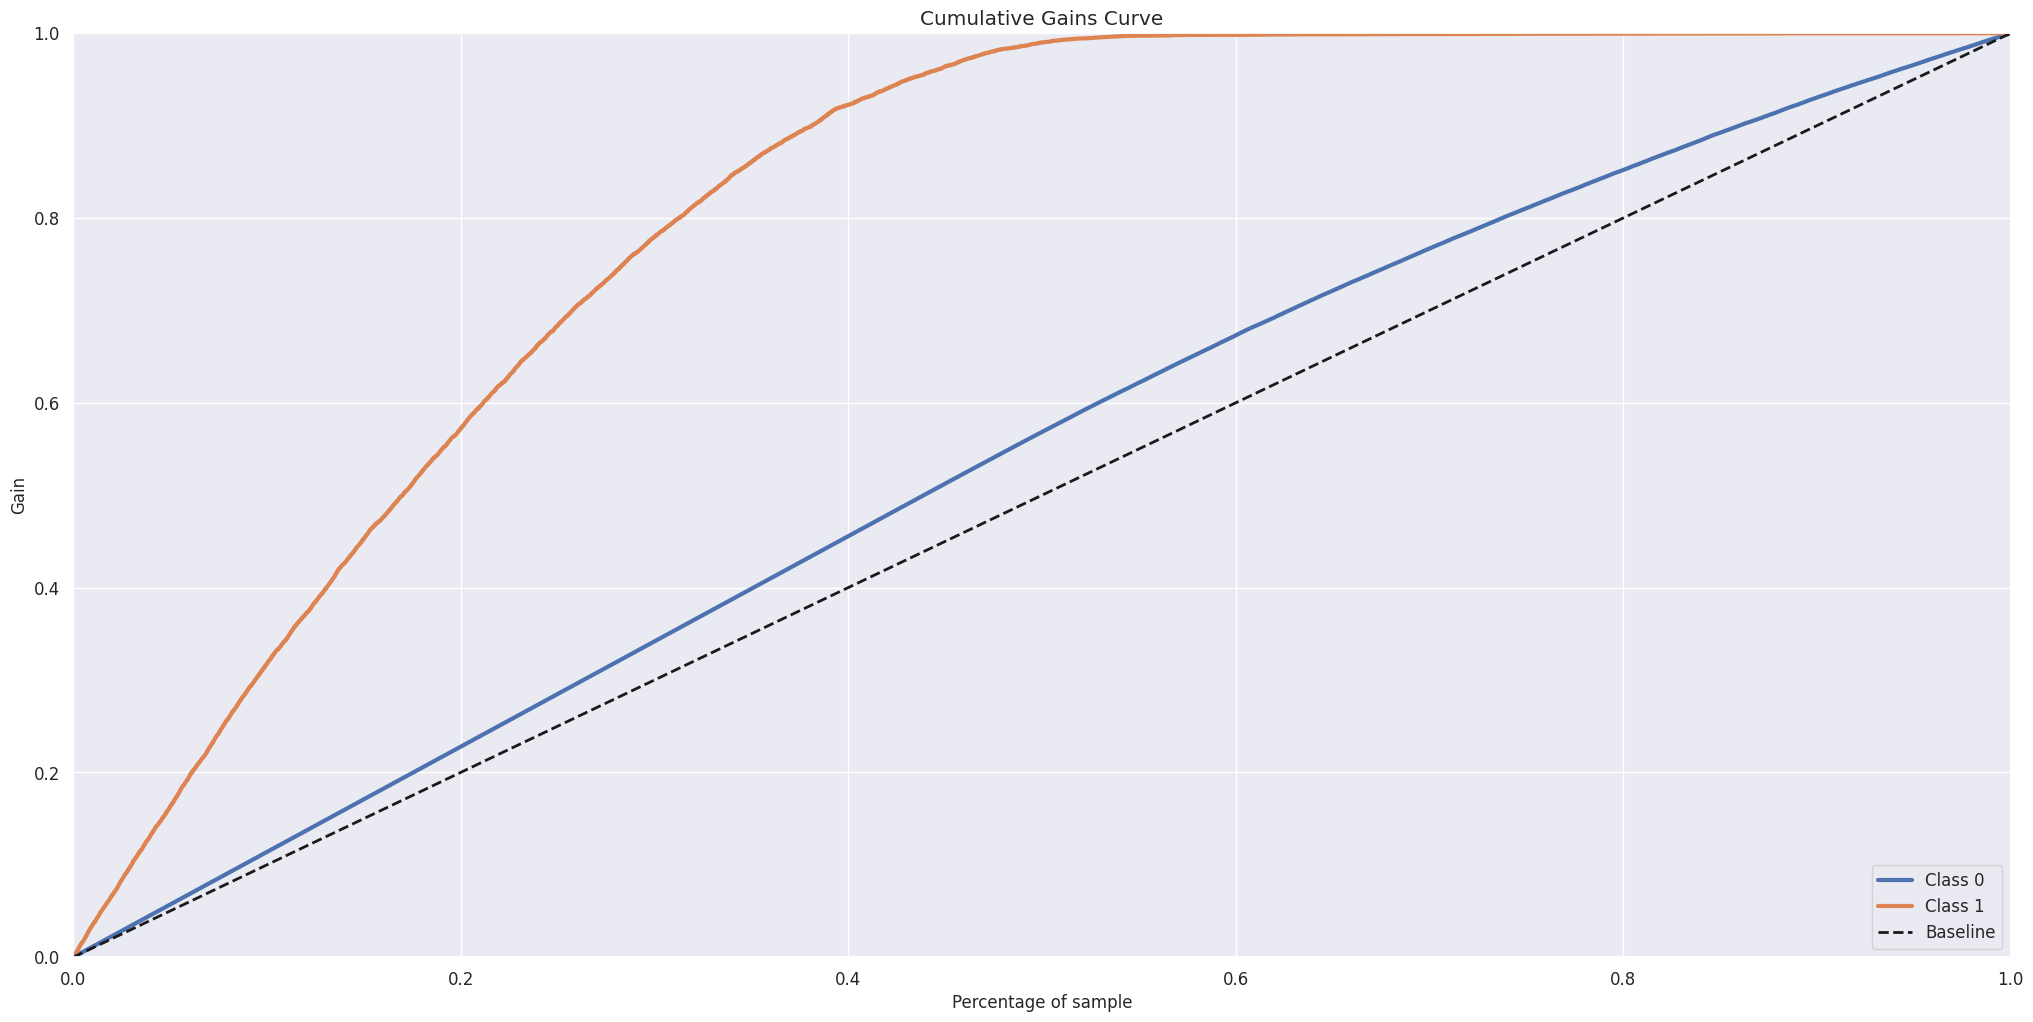

In [66]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_cat)

In [68]:
print(f'Precision at k: {precision_at_k(df8, yhat_cat)}')
print(f'Recall at k: {recall_at_k(df8, yhat_cat)}')

Precision at k: 0.33103344832758363
Recall at k: 0.7087347463070006


#### Cross Validation

In [69]:
cv_cat = cross_validation(knn_model, 5, X_train_cv, y_train_cv)
cv_cat

/tmp/ipykernel_9484/1276913504.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_9484/1276913504.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_9484/1276913504.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

/tmp/ipykernel_9484/1276913504.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
/tmp/ipykernel_9484/1276913504.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_9484/1276913504.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

/tmp/ipykernel_9484/1276913504.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_9484/1276913504.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['age'] = mms_age.transform(X_test_fold[['age']].values)
/tmp/ipykernel_9484/1276913504.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/ipykernel_9484/1276913504.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_9484/1276913504.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_9484/1276913504.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

,Model,Precision at k,Recall at k
0,KNeighborsClassifier,0.2846+/-0.0014,0.7616+/-0.0038


## 7.2 Model Performance

In [72]:
performance = pd.concat([cv_knn, cv_lr, cv_rf, cv_xgb, cv_lgbm, cv_cat])
performance.sort_values('Recall at k', ascending=False)

,Model,Precision at k,Recall at k
0,LGBMClassifier,0.3101+/-0.0019,0.8298+/-0.0052
0,XGBClassifier,0.3088+/-0.0019,0.8264+/-0.0049
0,RandomForestClassifier,0.2914+/-0.0012,0.7798+/-0.0031
0,KNeighborsClassifier,0.2846+/-0.0014,0.7616+/-0.0038
0,KNeighborsClassifier,0.2846+/-0.0014,0.7616+/-0.0038
0,LogisticRegression,0.2753+/-0.0019,0.7368+/-0.0052
